In [15]:
import torch
import torch.nn as nn
from torch.nn.utils.parametrizations import weight_norm

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class TCNPredictor(nn.Module):
    def __init__(self, num_shops, num_channels, kernel_size, dropout, pred_length, d_model=4, num_heads=2):

        super(TCNPredictor, self).__init__()
        self.num_shops = num_shops
        self.pred_length = pred_length
        self.d_model = d_model

        if num_channels[-1] != num_shops * d_model:
            raise ValueError("The last channel dimension must equal num_shops * d_model for reshaping.")
        
        self.tcn = TemporalConvNet(num_shops, num_channels, kernel_size, dropout)
        

        if d_model % num_heads != 0:
            raise ValueError("d_model must be divisible by num_heads.")
        
        self.attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads)
        
        self.linear = nn.Linear(num_shops * d_model, num_shops * pred_length)
        self.attn_weights = None  

    def forward(self, x):
        # x shape: [batch_size, num_shops, sequence_length]
        batch_size = x.size(0)
        
        x = self.tcn(x)  # [batch_size, num_shops*d_model, sequence_length]
        
        x = x[:, :, -1]
        
        x = x.view(batch_size, self.num_shops, self.d_model)

        x = x.permute(1, 0, 2)  # [num_shops, batch_size, d_model]
        
        attn_output, attn_weights = self.attention(x, x, x)  # [num_shops, batch_size, d_model]
        
        self.attn_weights = attn_weights.detach().cpu().numpy()

        attn_output = attn_output.permute(1, 0, 2)
        
        attn_output = attn_output.contiguous().view(batch_size, self.num_shops * self.d_model)
        
        out = self.linear(attn_output)  # [batch_size, num_shops * pred_length]
        
        out = out.view(batch_size, self.num_shops, self.pred_length)
        return out


In [16]:
def smape(actual, predicted):
    numerator = np.abs(predicted - actual)
    denominator = (np.abs(actual) + np.abs(predicted)) / 2.0
    valid_mask = (denominator != 0)
    smape_val = 100.0 * np.mean((numerator[valid_mask] / denominator[valid_mask]))
    return smape_val

Sales matrix shape: (46, 34)
Train data shape: (46, 26)
Val data shape: (46, 4)
Test data shape: (46, 4)
Train sequences shape: (11, 46, 12)
Train targets shape: (11, 46, 4)
Val history shape: (46, 16)
Val sequences shape: (1, 46, 12)
Val targets shape: (1, 46, 4)
Test history shape: (46, 8)
Test sequences before reshape: (46, 8)
Test sequences after reshape: (1, 46, 8)
Gradient max abs value: 3.565854058251716e-06
Gradient max abs value: 2.0991055862396024e-06
Gradient max abs value: 2.407073907306767e-06
Gradient max abs value: 5.2144541768939234e-06
Gradient max abs value: 1.2662144399655517e-06
Gradient max abs value: 3.1667059374740347e-06
Gradient max abs value: 4.048973551107338e-06
Gradient max abs value: 6.003344878990902e-06
Gradient max abs value: 1.177518606709782e-05
Gradient max abs value: 1.763973273227748e-06
Gradient max abs value: 3.583207444535219e-06
Gradient max abs value: 3.654654210549779e-05
Gradient max abs value: 2.5086189907597145e-06
Gradient max abs value: 

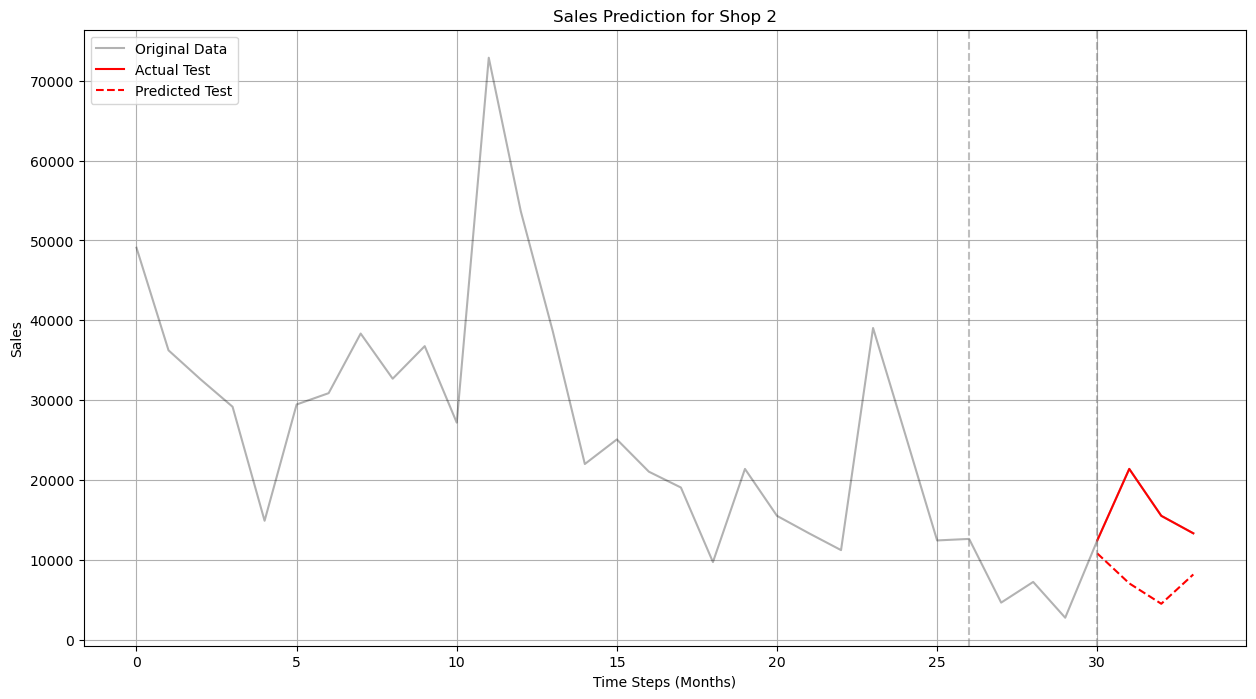


Shop 3:
MSE: 38236143.13
MAE: 4592.02


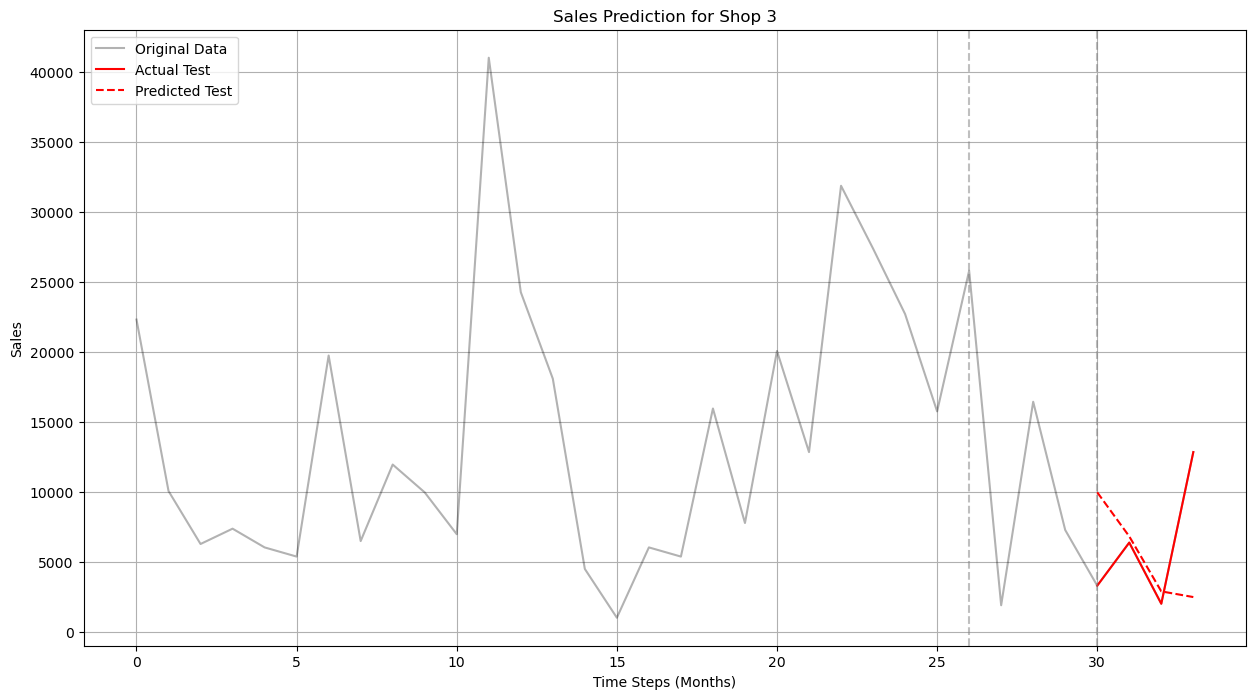


Shop 4:
MSE: 37282687.09
MAE: 5586.18


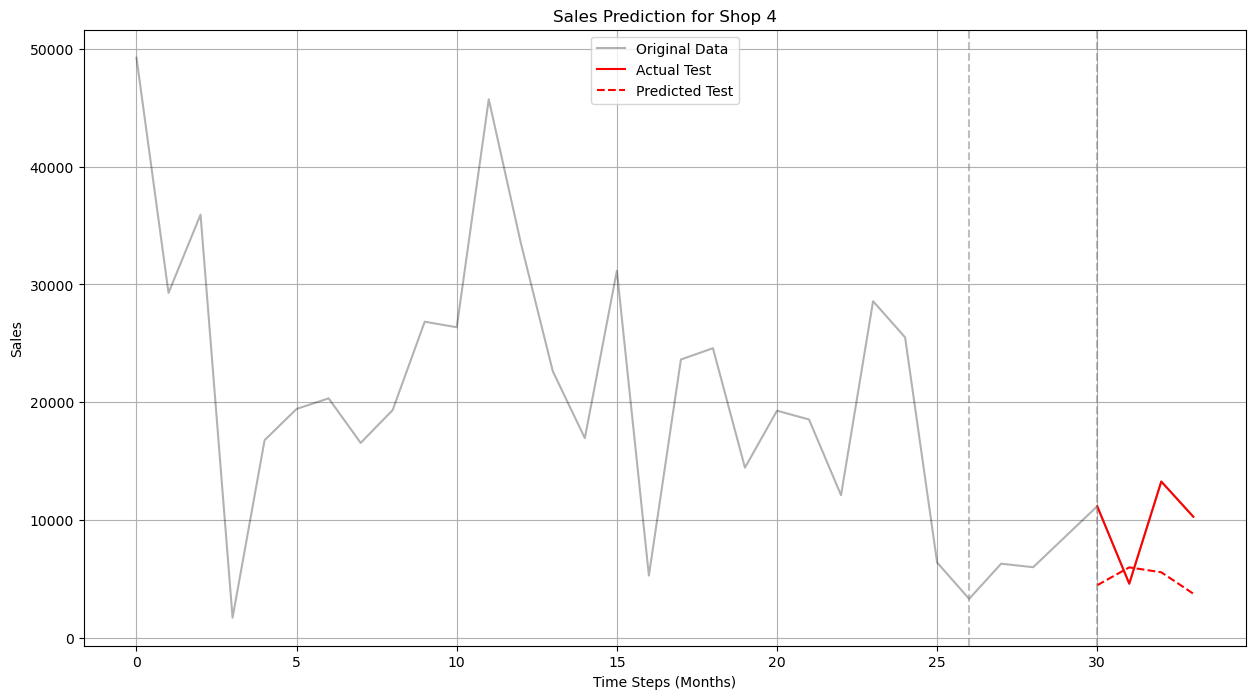


Shop 5:
MSE: 23297809.56
MAE: 3234.07


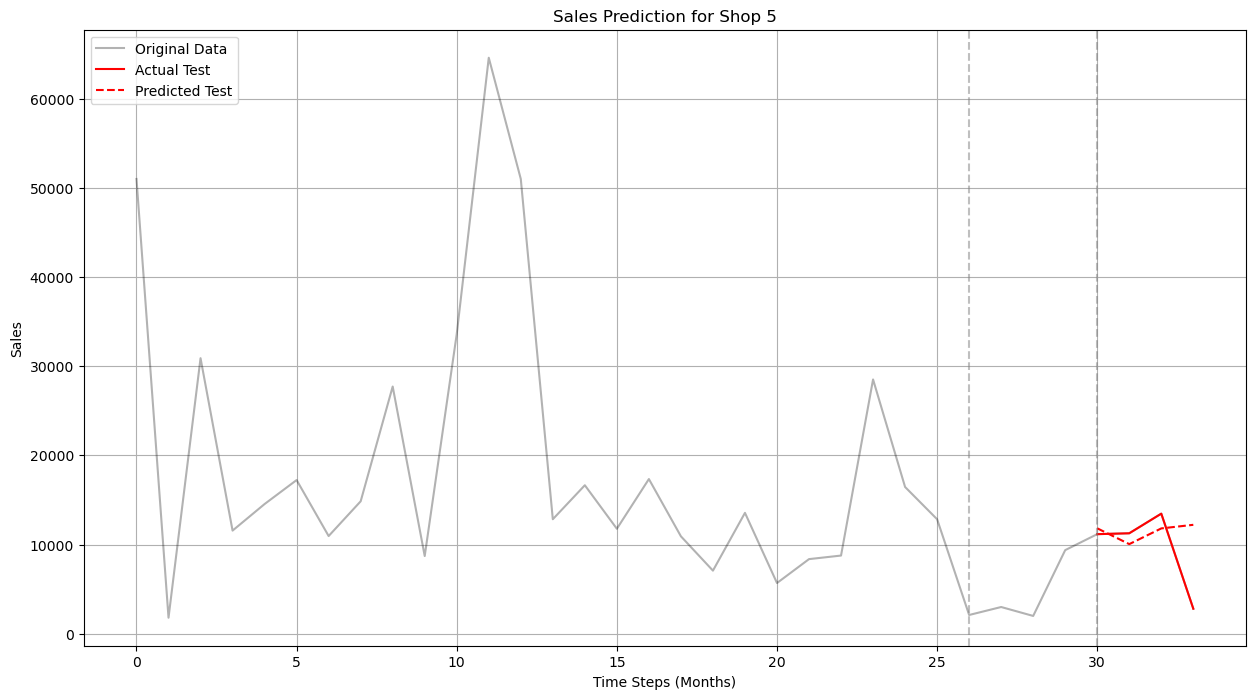


Shop 6:
MSE: 169344837.77
MAE: 11759.97


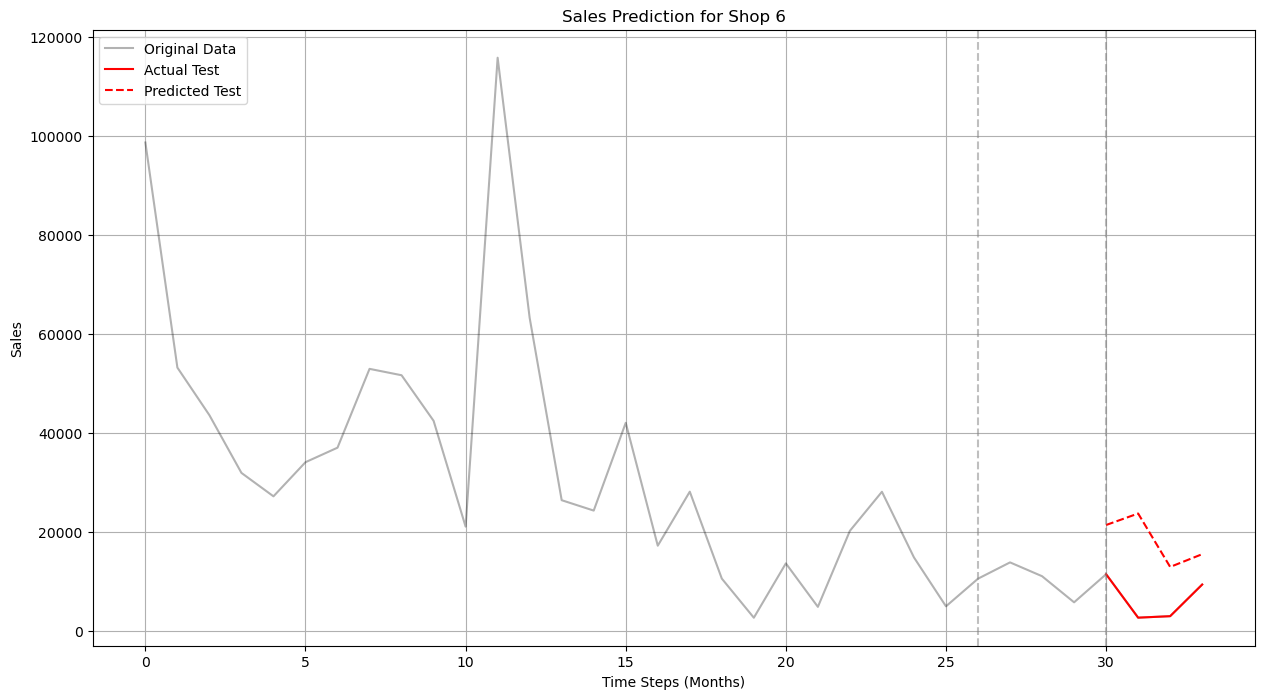


Shop 7:
MSE: 311375402.61
MAE: 16871.27


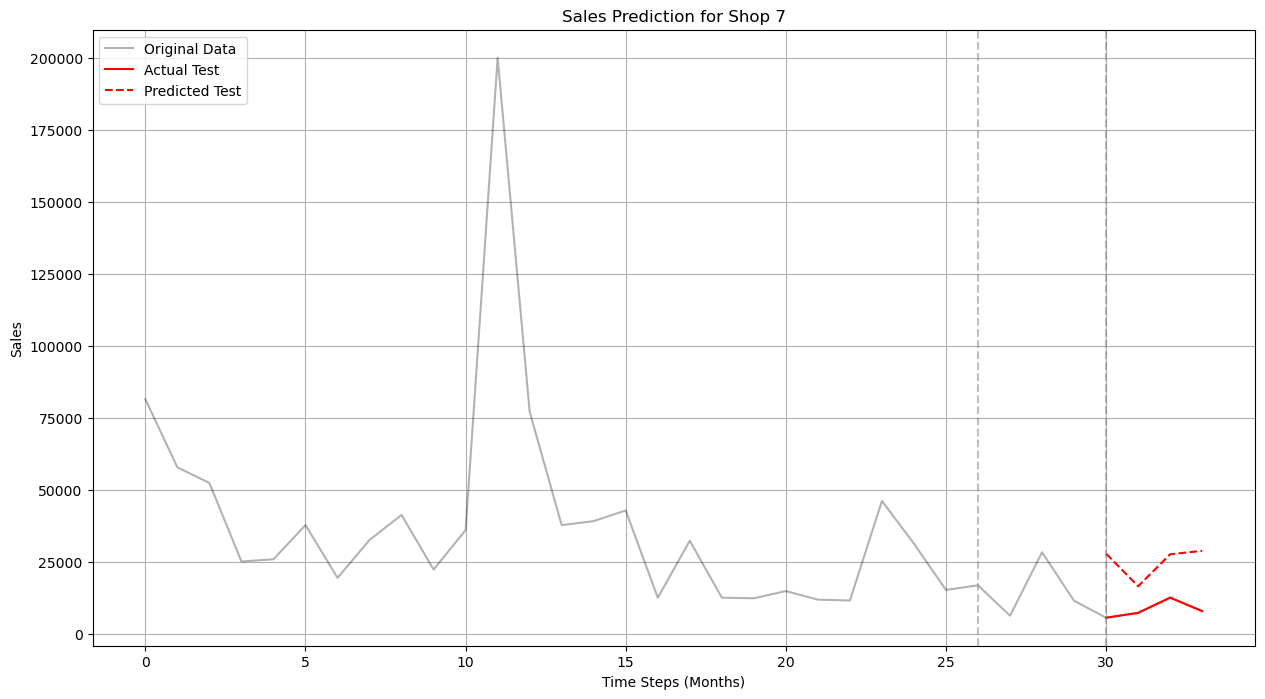


Shop 10:
MSE: 7022098.38
MAE: 2286.80


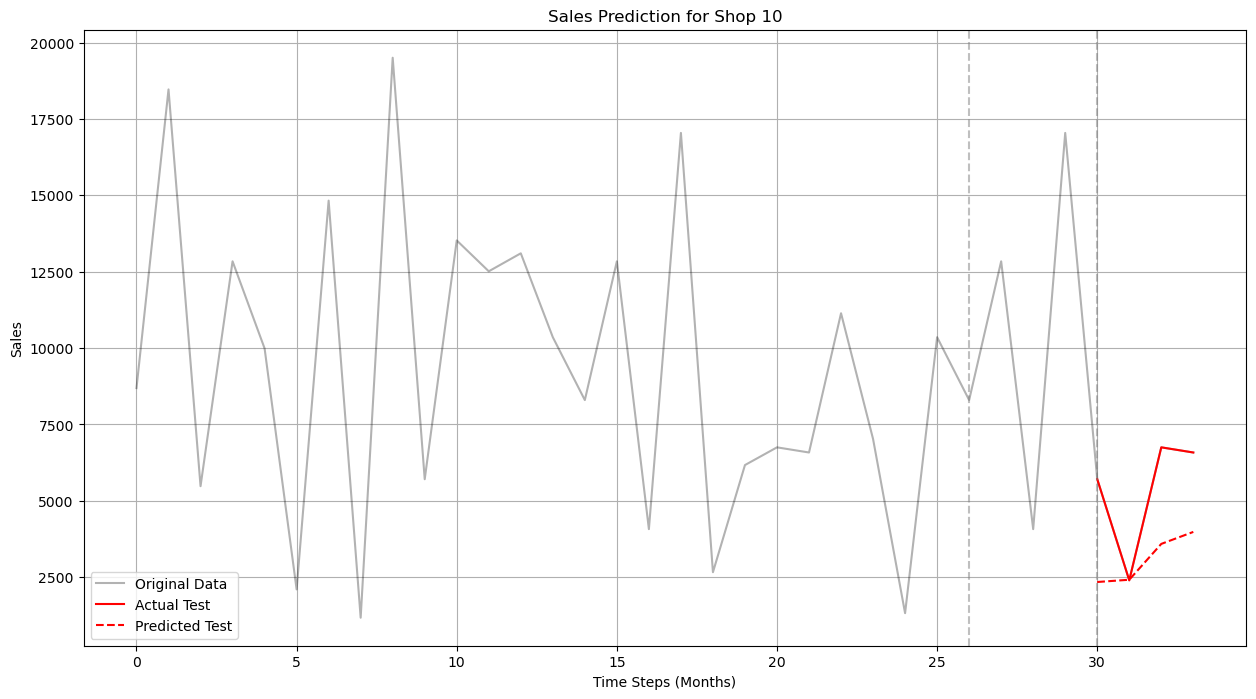


Shop 12:
MSE: 26594537.03
MAE: 4575.57


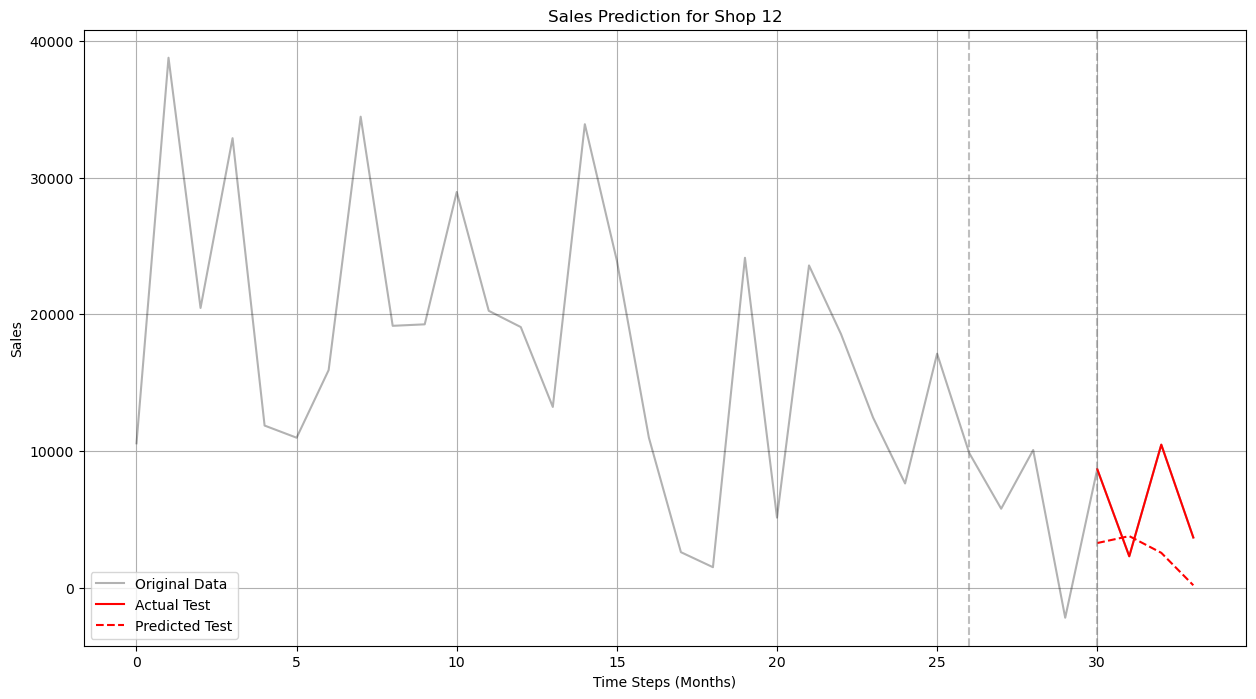


Shop 14:
MSE: 106900303.85
MAE: 9518.19


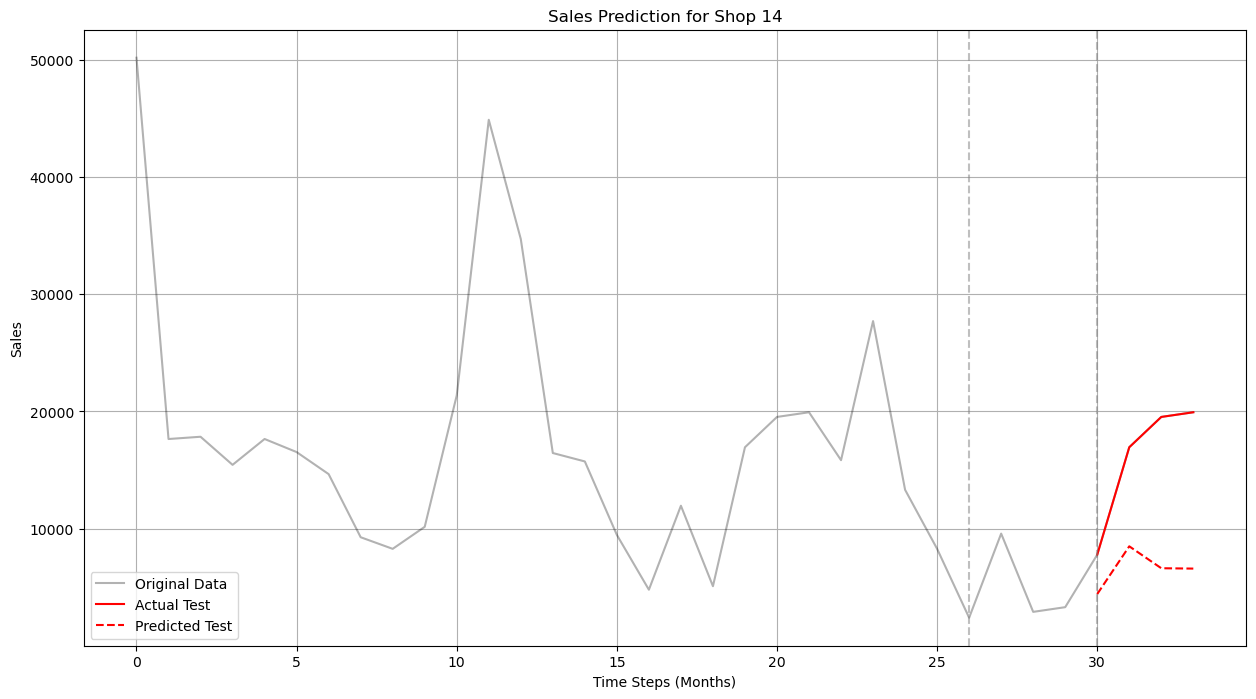


Shop 15:
MSE: 23107908.11
MAE: 3380.00


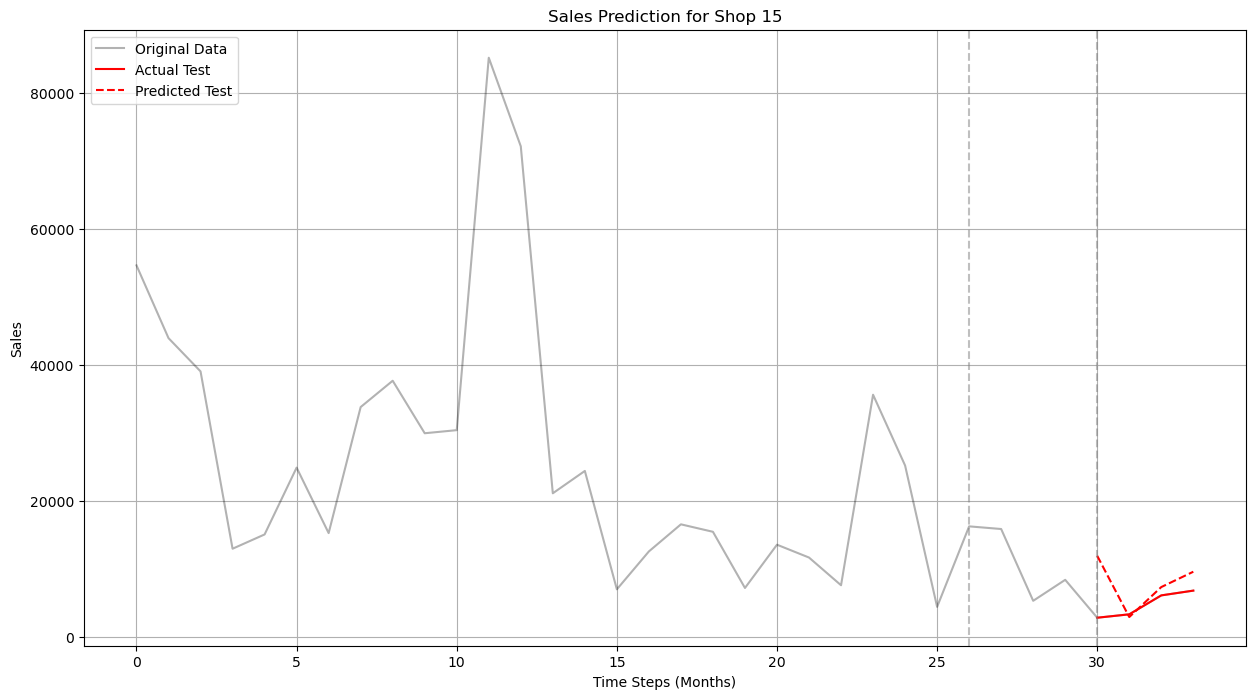


Shop 16:
MSE: 65557143.91
MAE: 7065.63


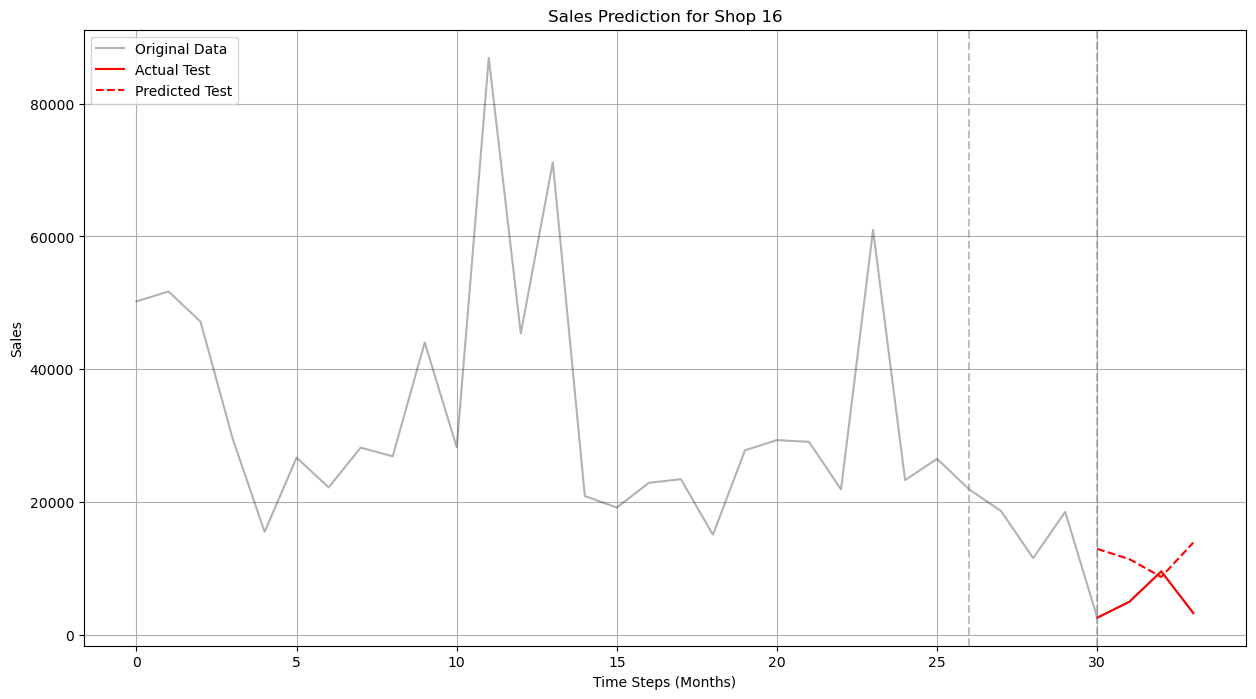


Shop 17:
MSE: 19026292.12
MAE: 2709.50


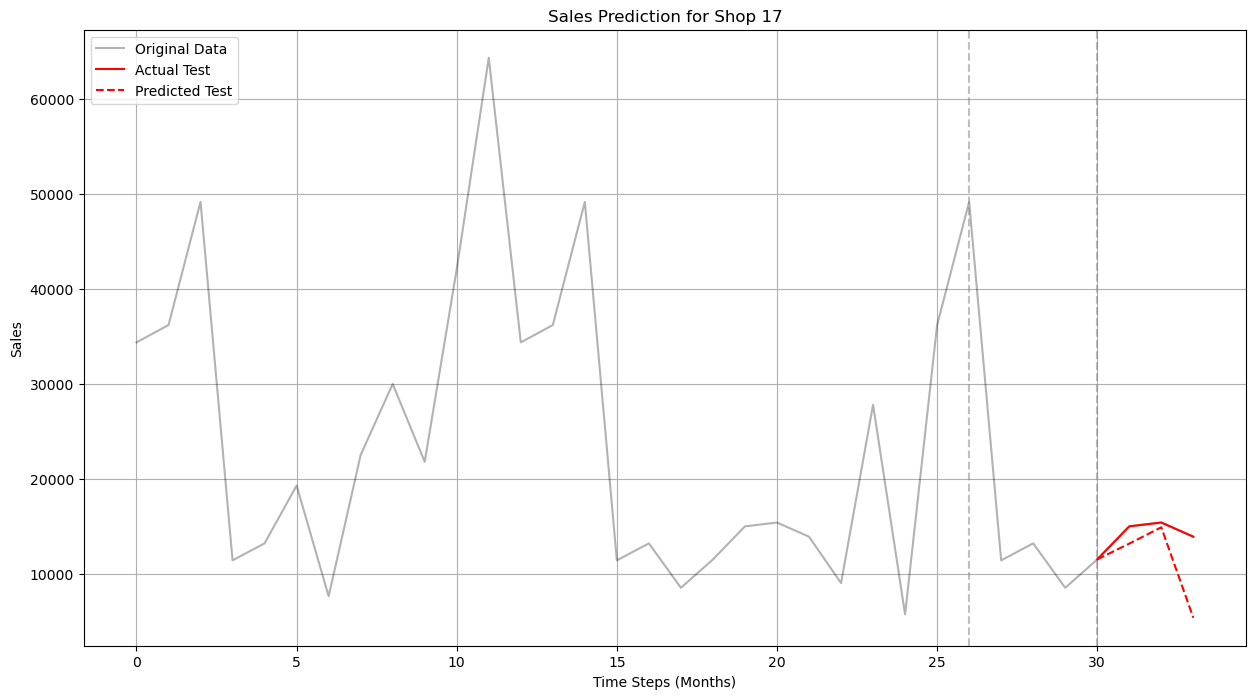


Shop 18:
MSE: 518940923.79
MAE: 20483.15


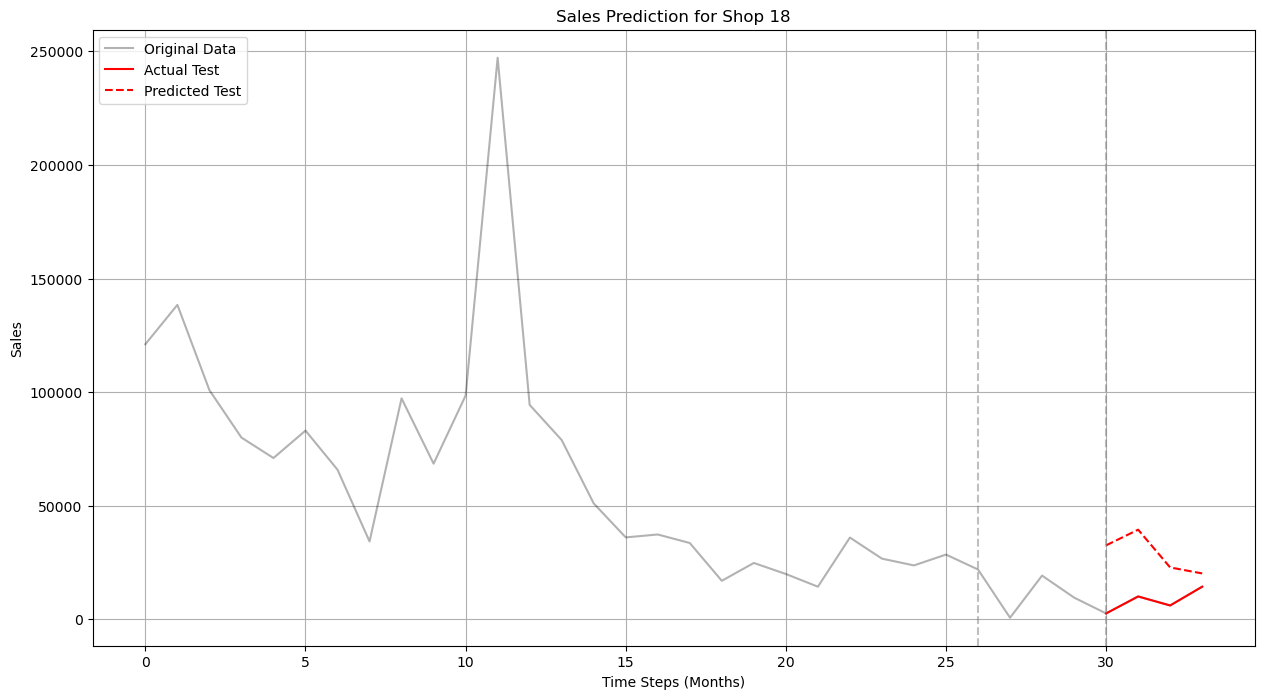


Shop 19:
MSE: 34384911.46
MAE: 4903.45


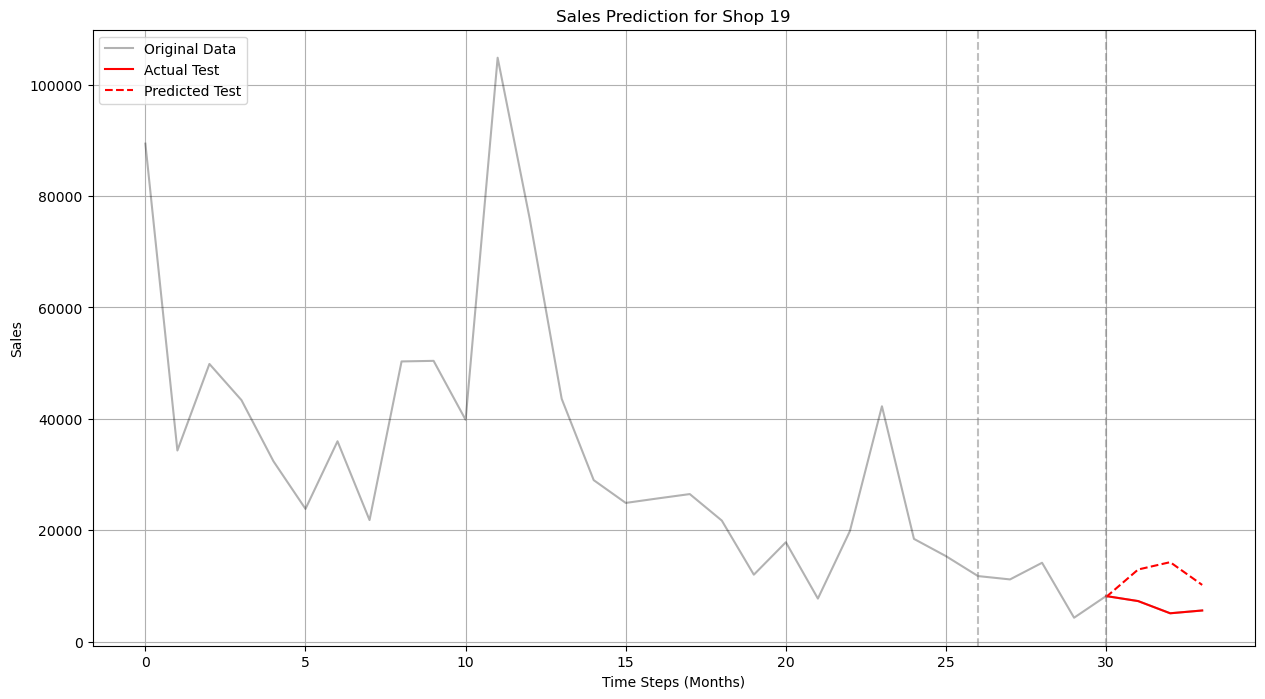


Shop 21:
MSE: 6978312.21
MAE: 2199.84


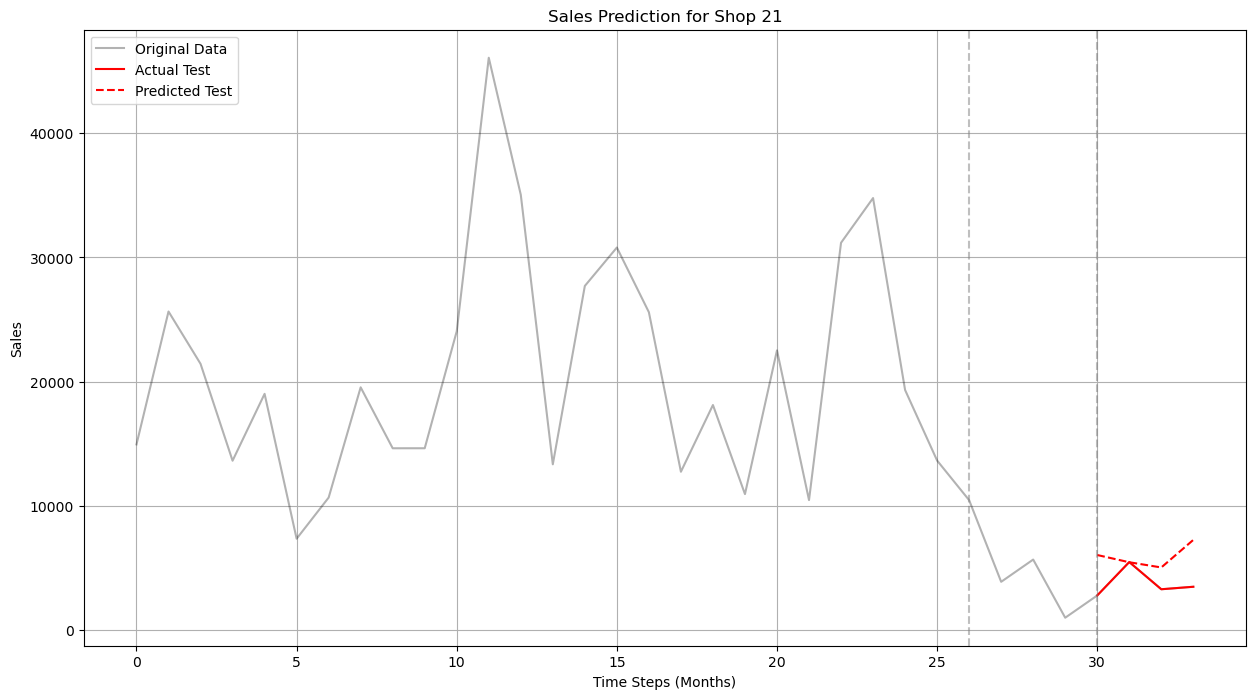


Shop 22:
MSE: 118932679.69
MAE: 9698.12


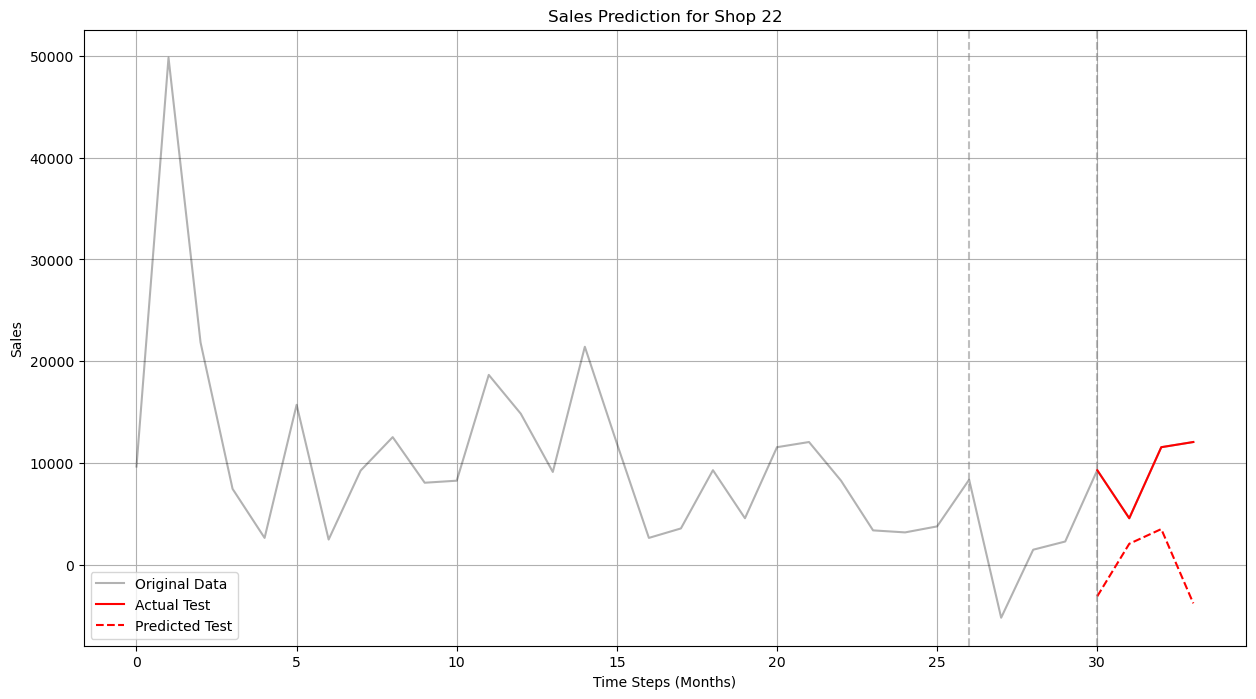


Shop 24:
MSE: 51961418.23
MAE: 5838.80


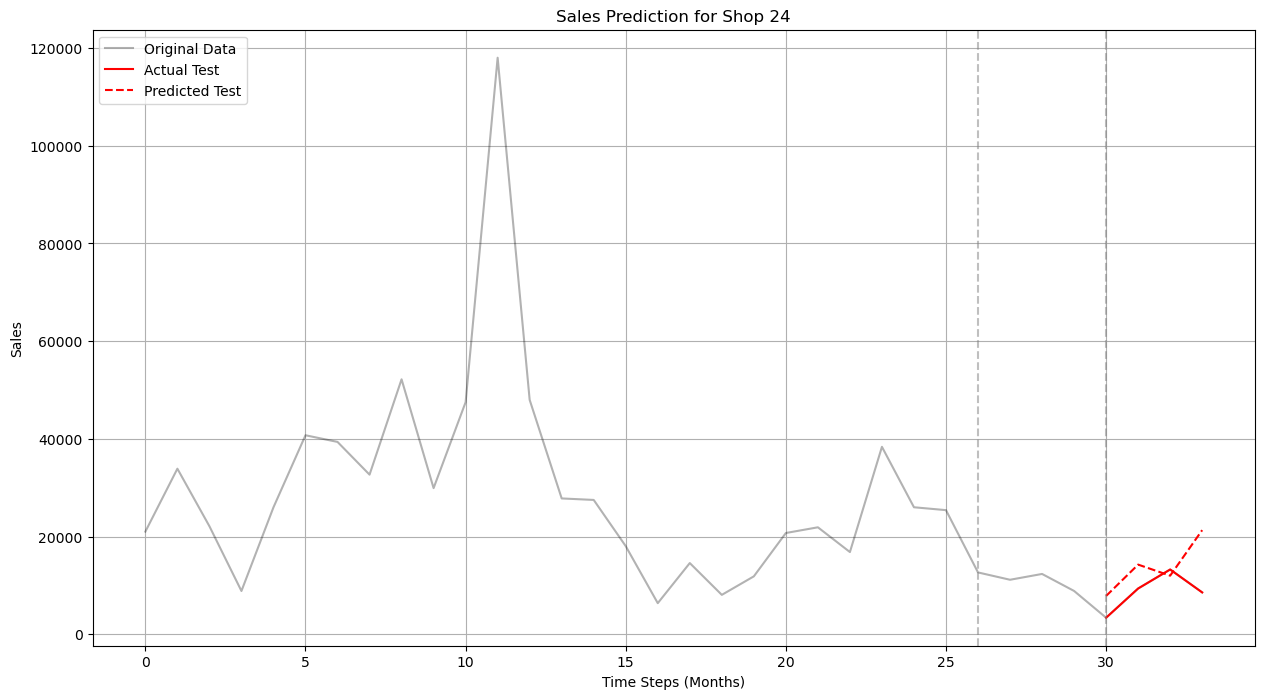


Shop 25:
MSE: 221403982.21
MAE: 11749.87


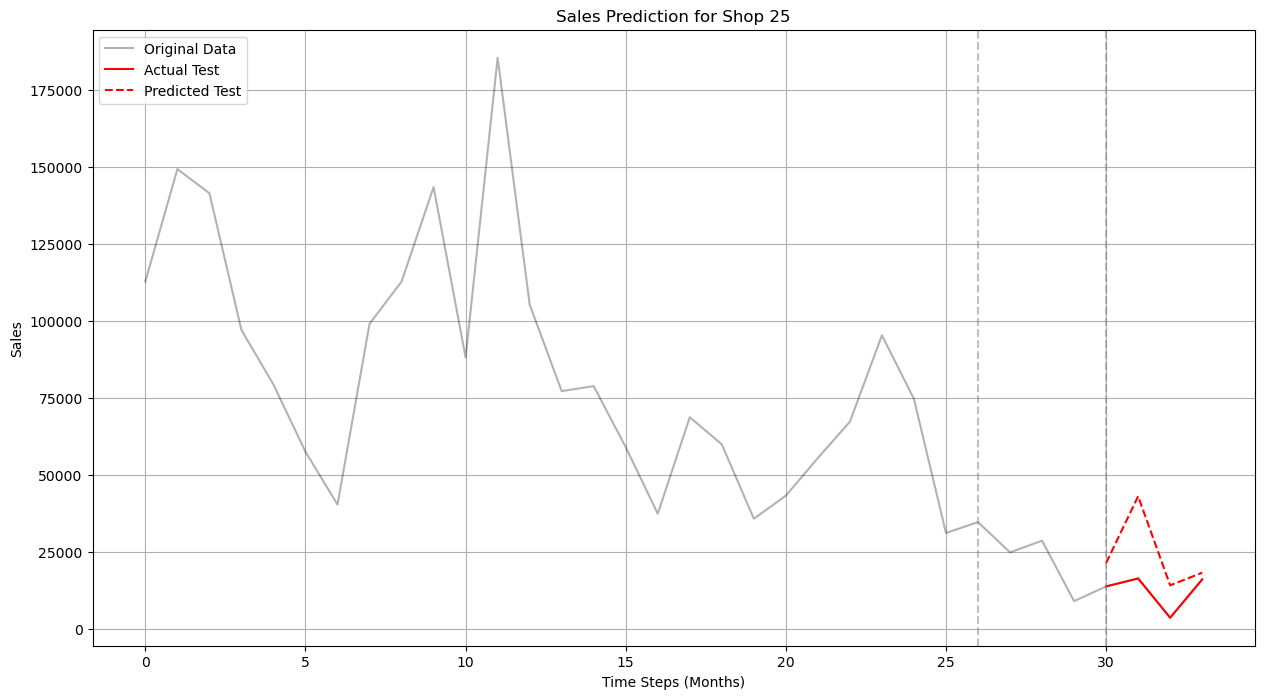


Shop 26:
MSE: 26550531.23
MAE: 4763.08


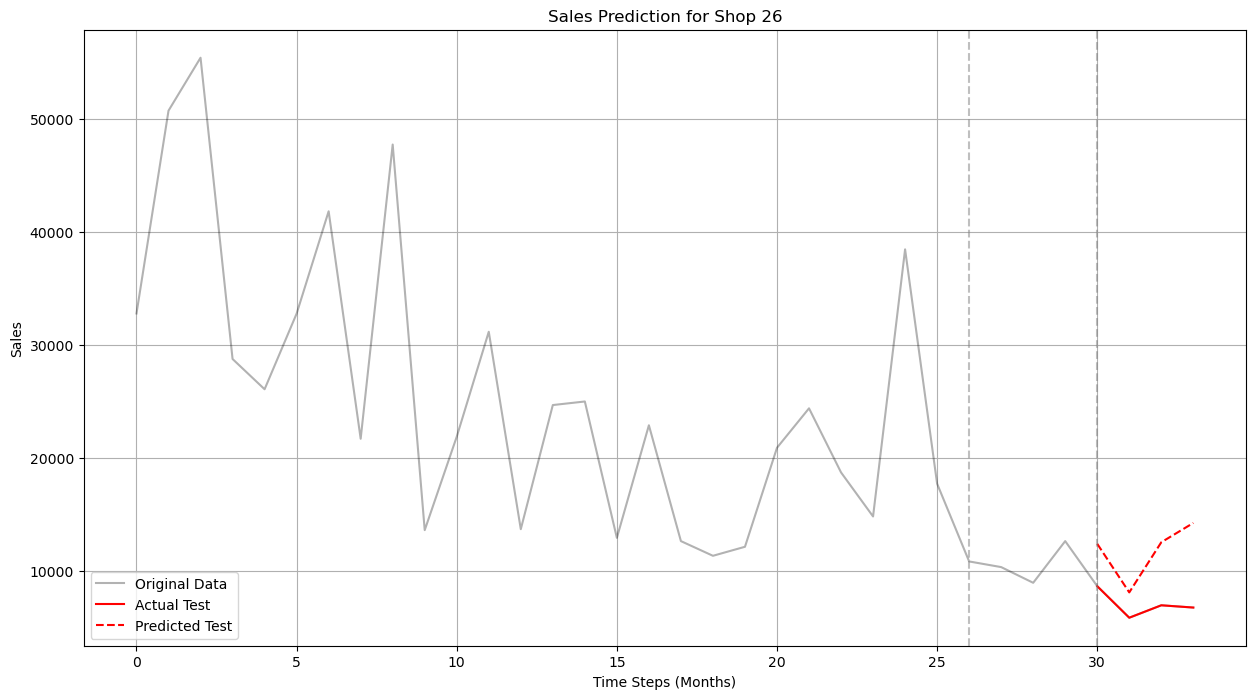


Shop 27:
MSE: 997784375.59
MAE: 26772.87


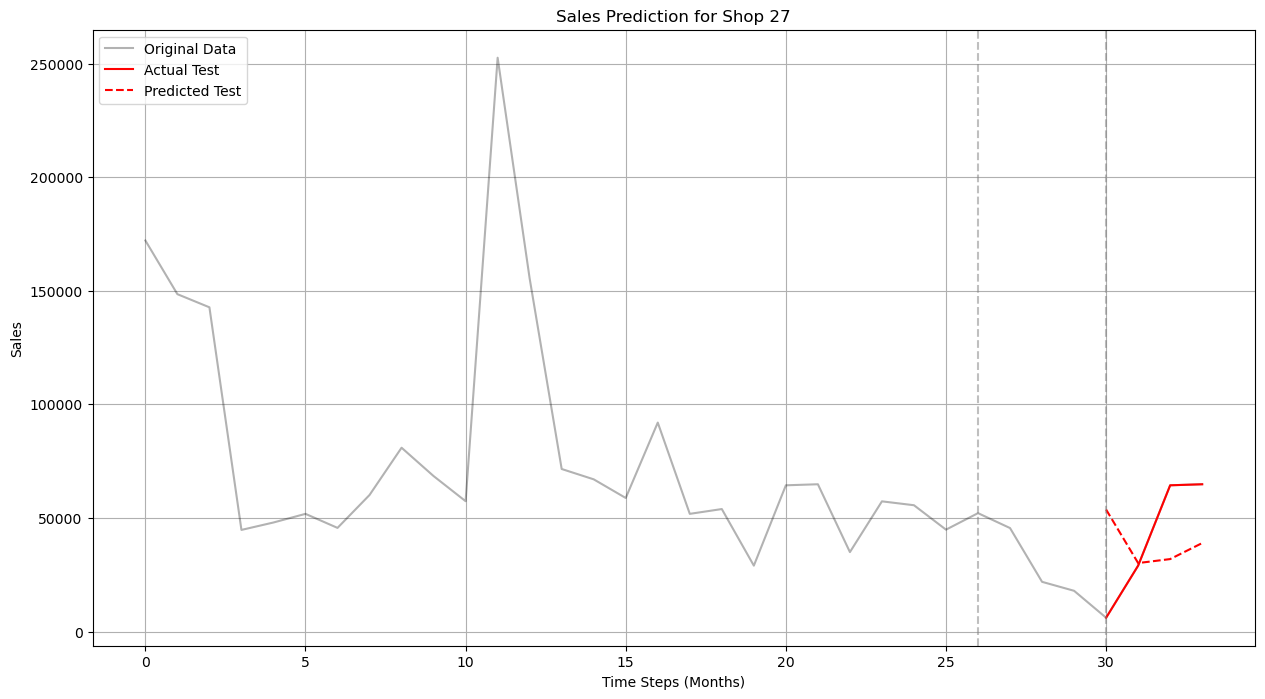


Shop 28:
MSE: 80728613.92
MAE: 8319.07


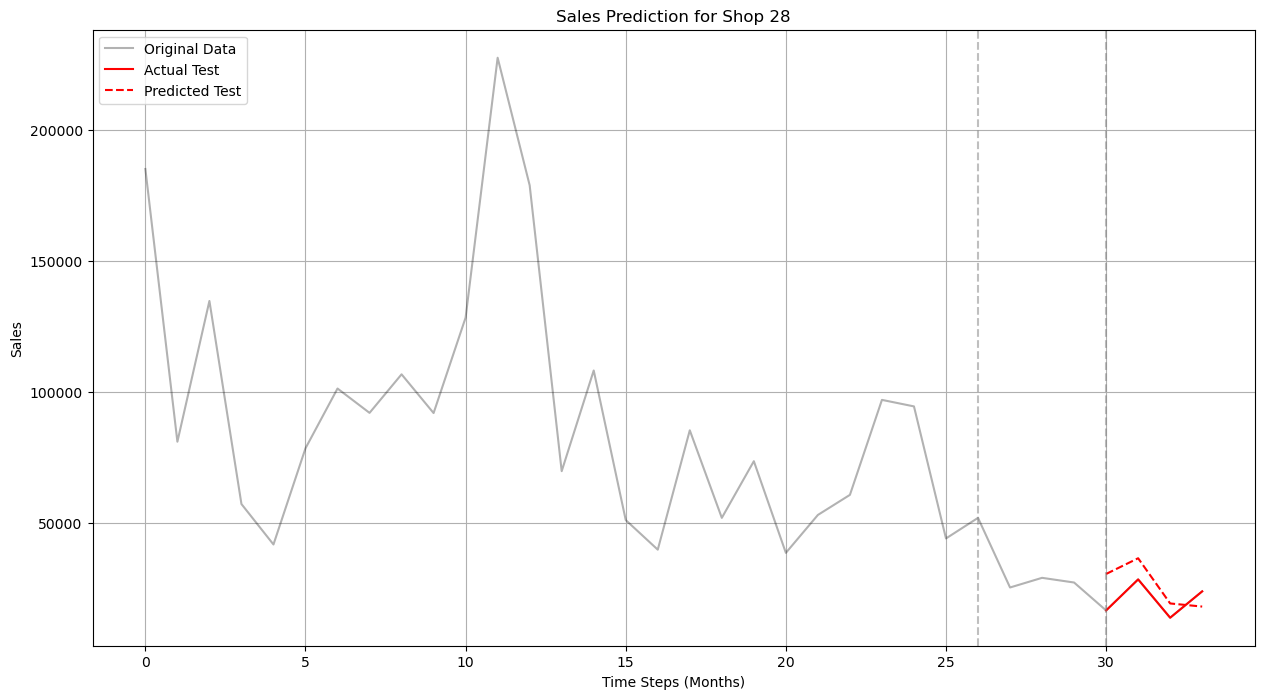


Shop 29:
MSE: 85591719.15
MAE: 7221.86


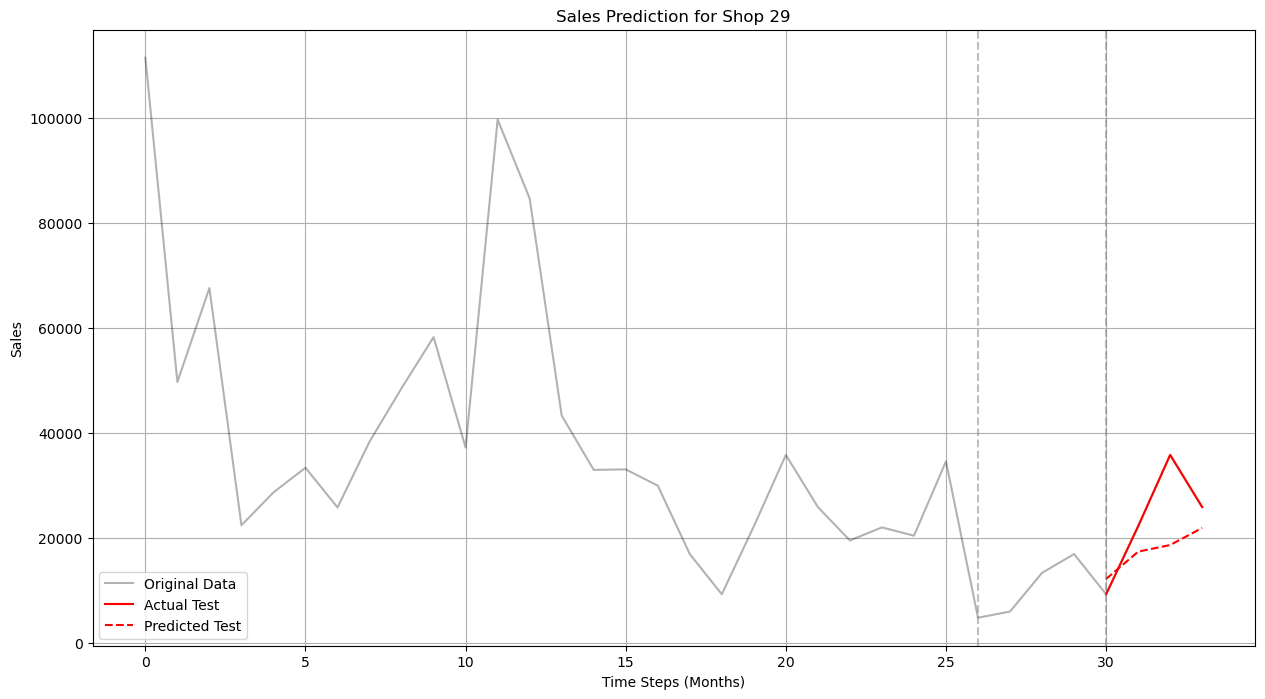


Shop 30:
MSE: 120517587.21
MAE: 9638.56


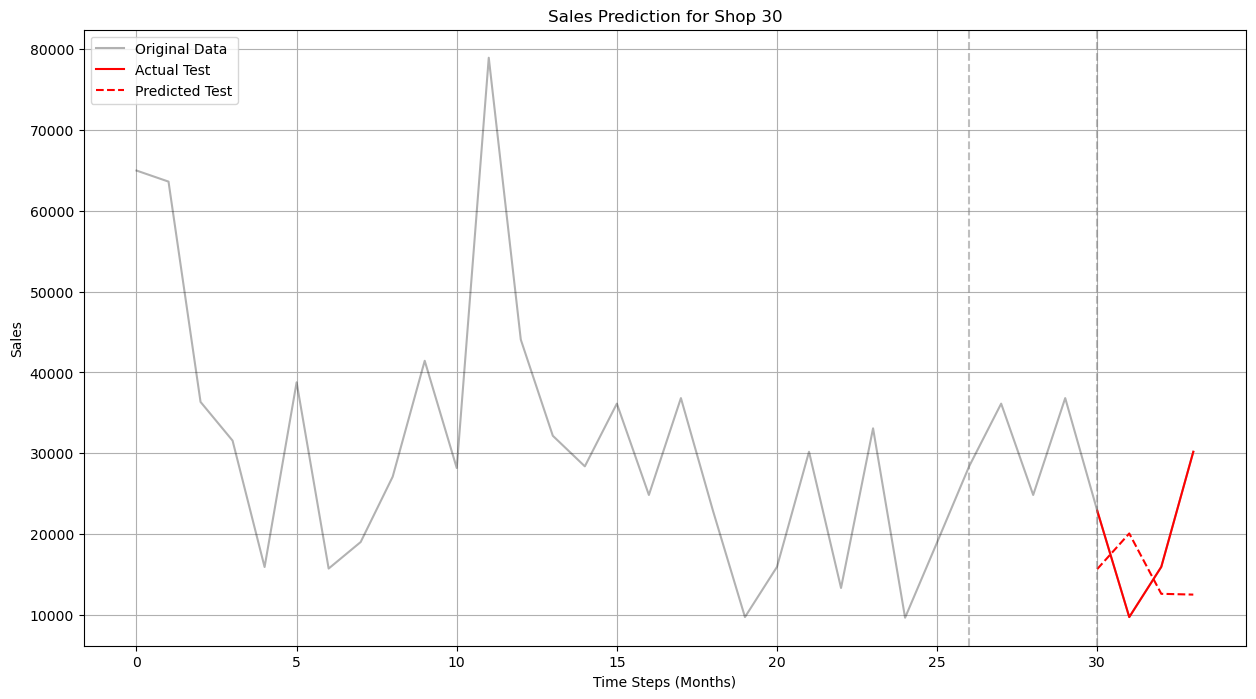


Shop 31:
MSE: 162485095.90
MAE: 11794.75


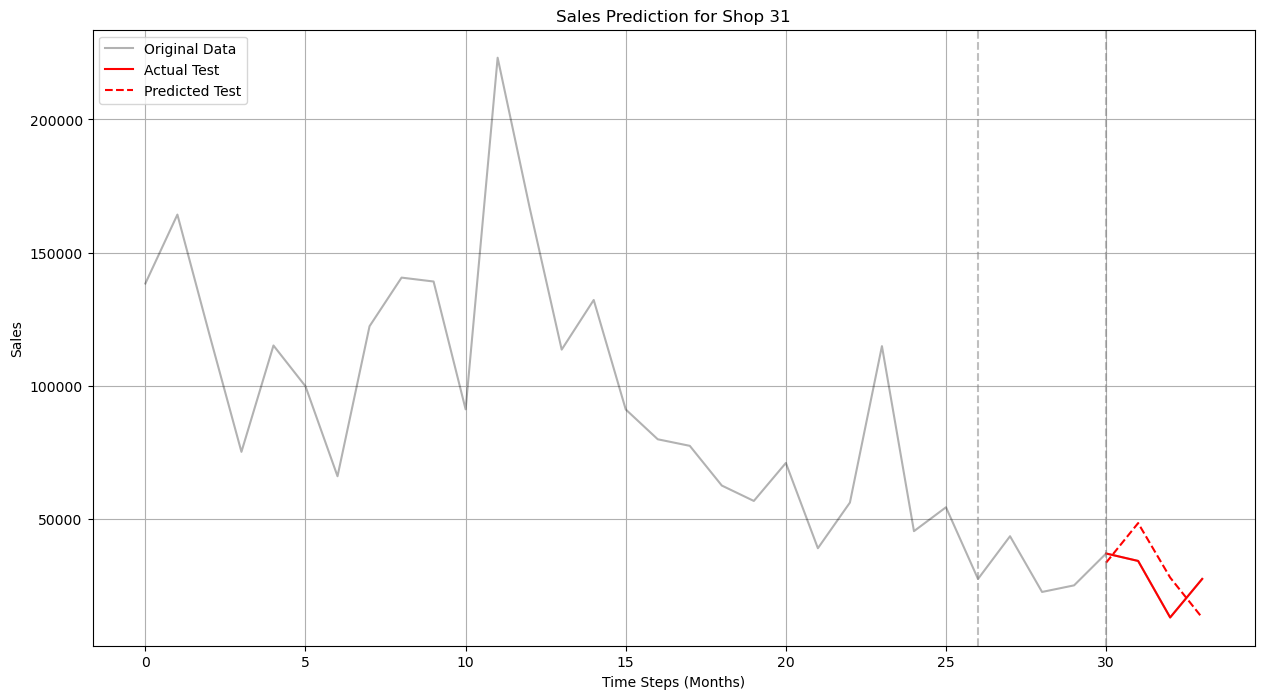


Shop 35:
MSE: 17264615.13
MAE: 3103.22


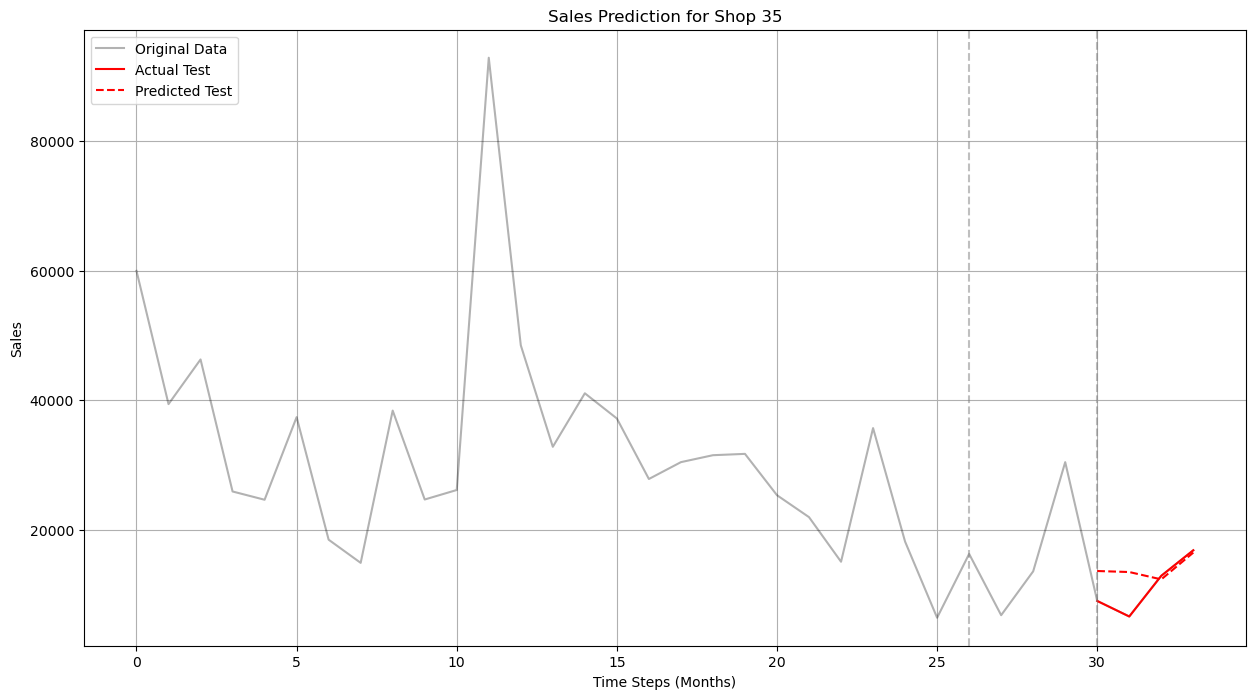


Shop 37:
MSE: 8909872.15
MAE: 2608.54


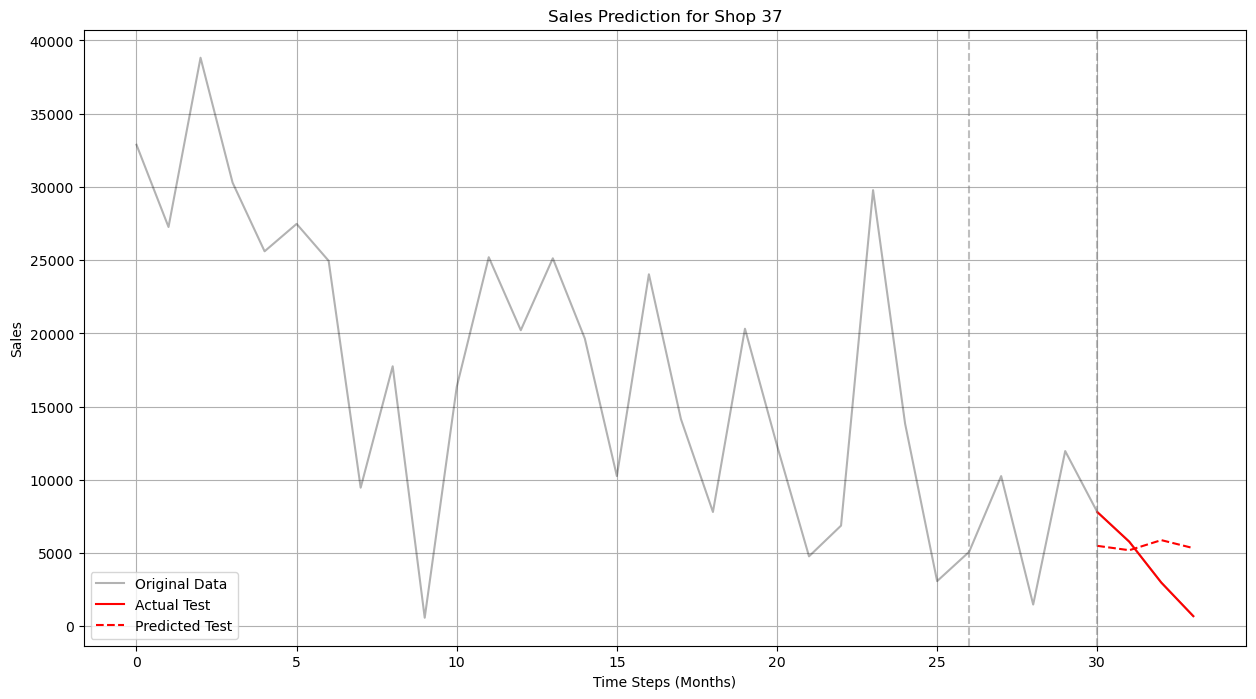


Shop 38:
MSE: 152272062.23
MAE: 11183.39


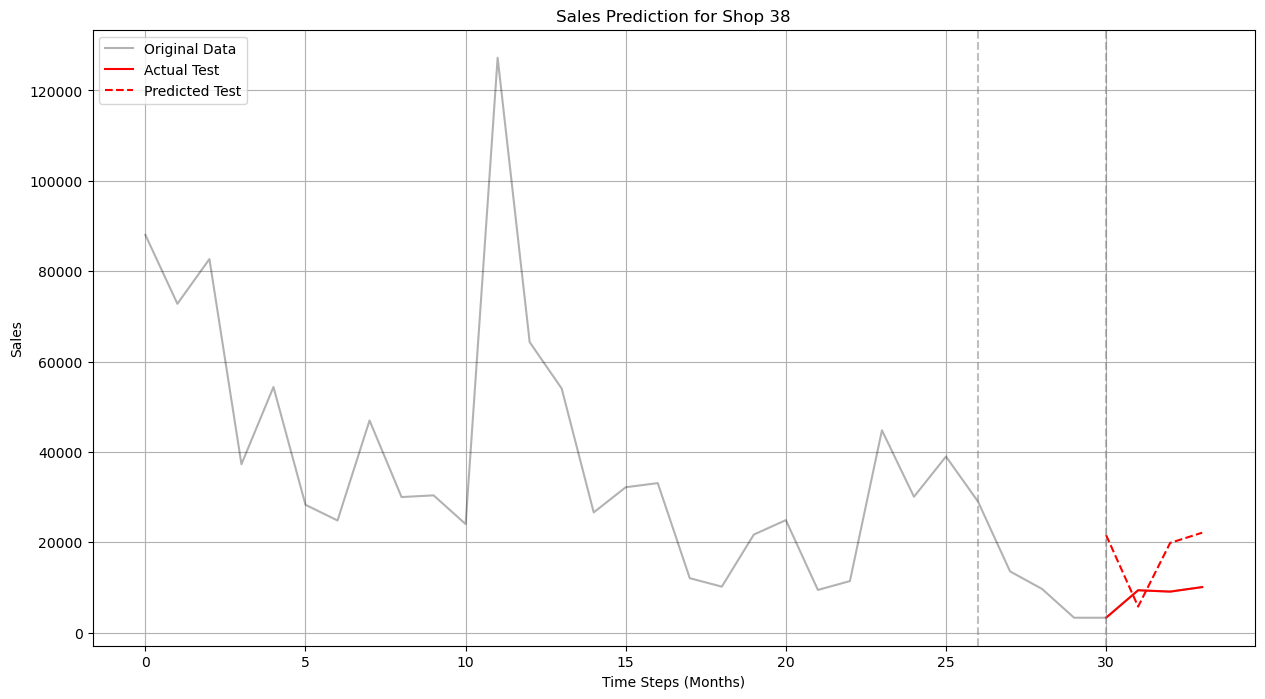


Shop 39:
MSE: 7725185.31
MAE: 2409.37


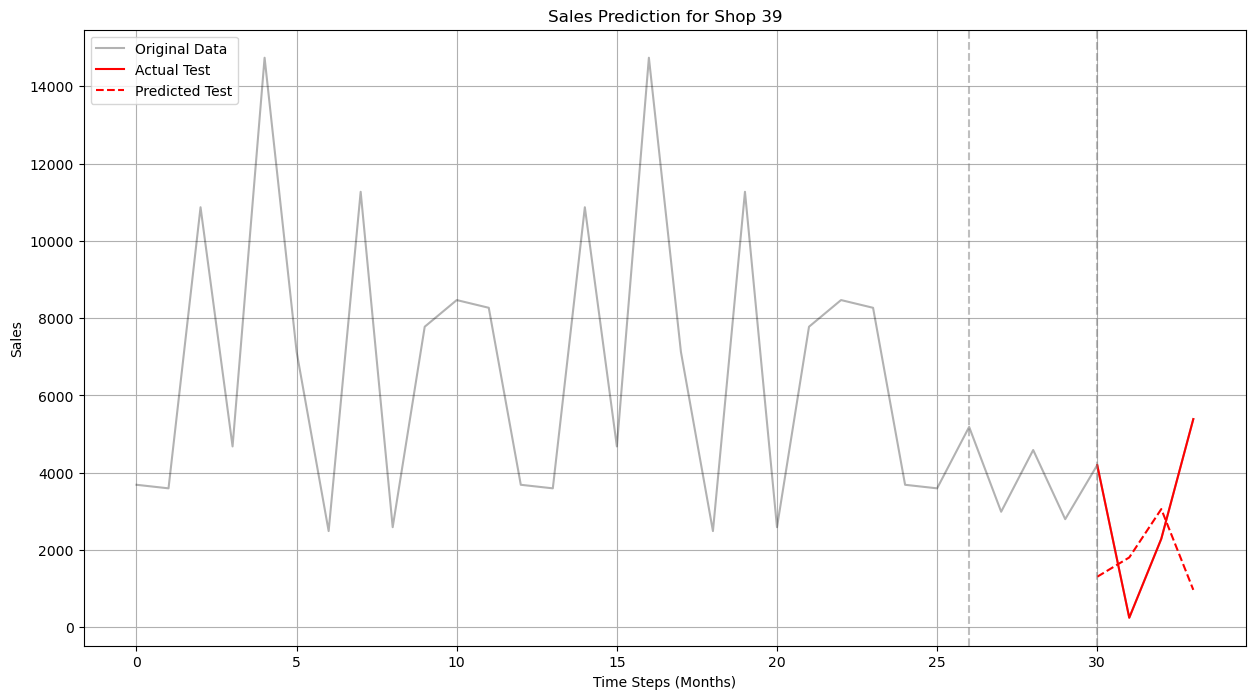


Shop 41:
MSE: 68927907.93
MAE: 7967.95


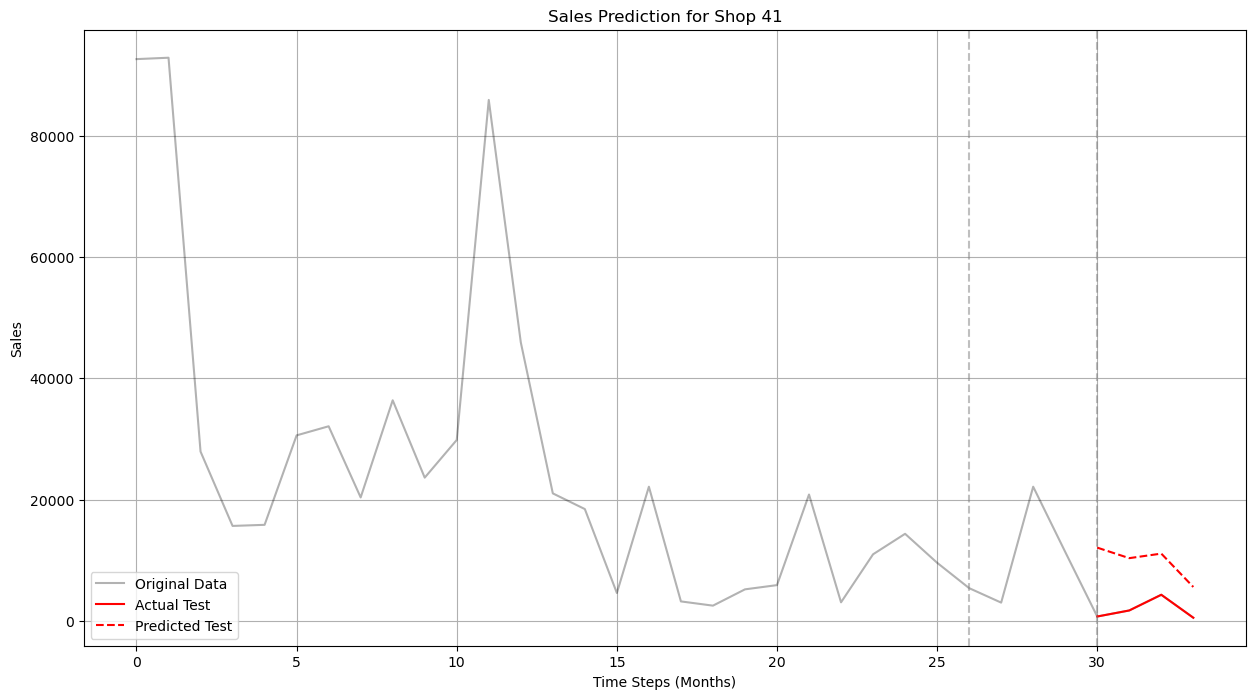


Shop 42:
MSE: 28723567.52
MAE: 4434.04


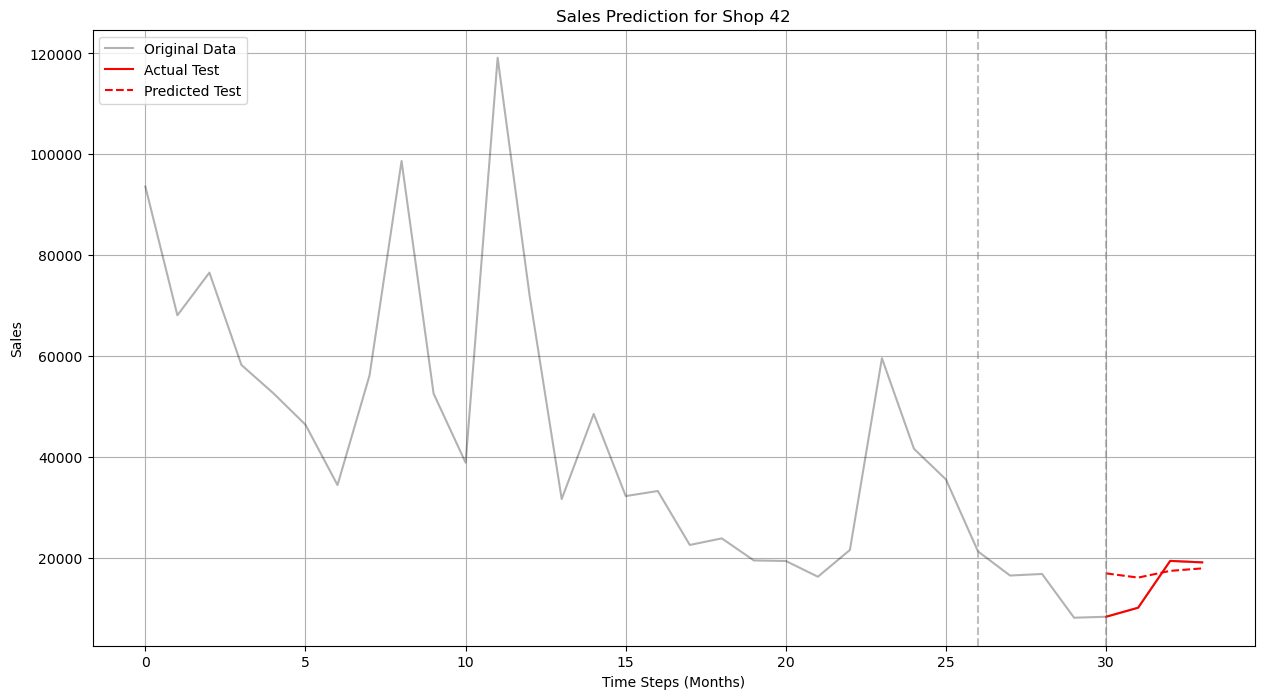


Shop 43:
MSE: 59465798.92
MAE: 5965.36


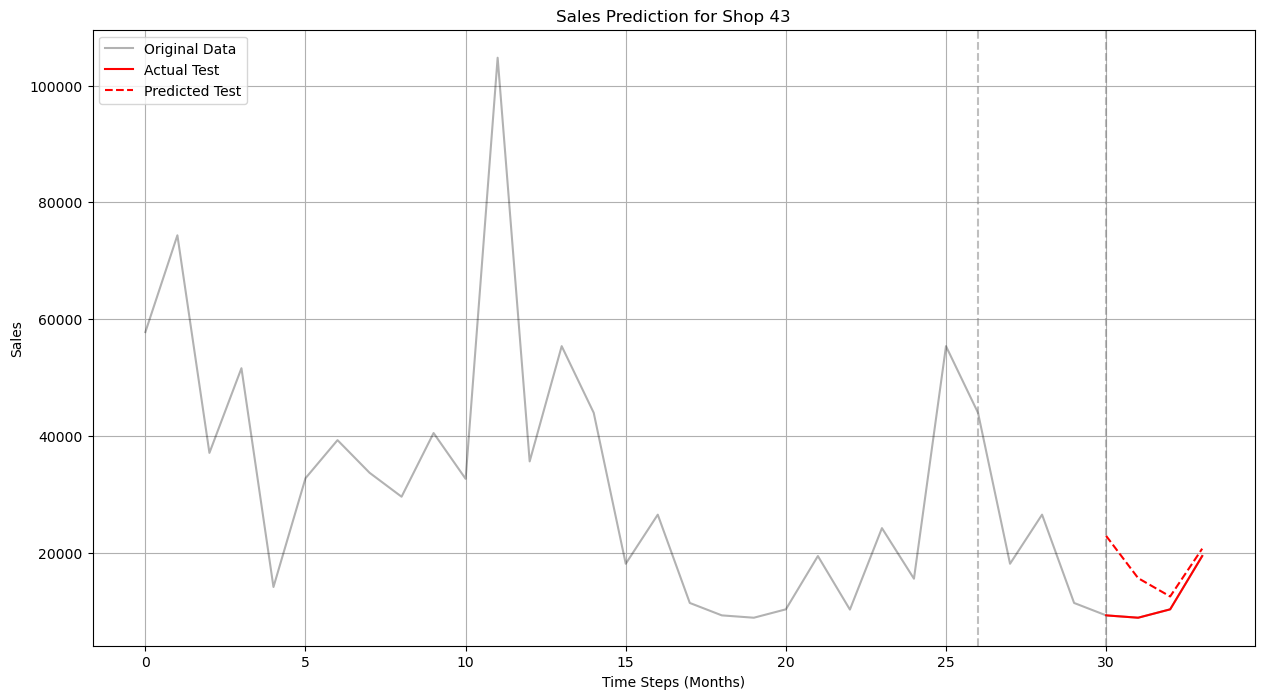


Shop 44:
MSE: 12004579.79
MAE: 2957.36


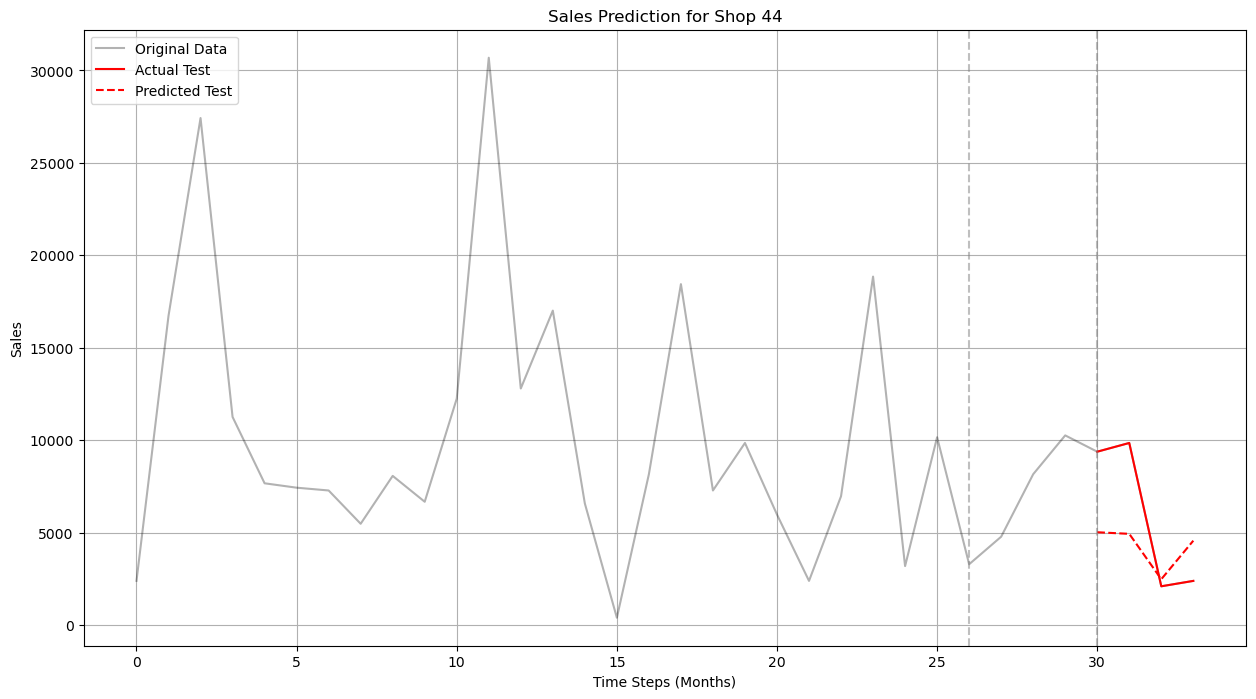


Shop 45:
MSE: 2780767.24
MAE: 1577.38


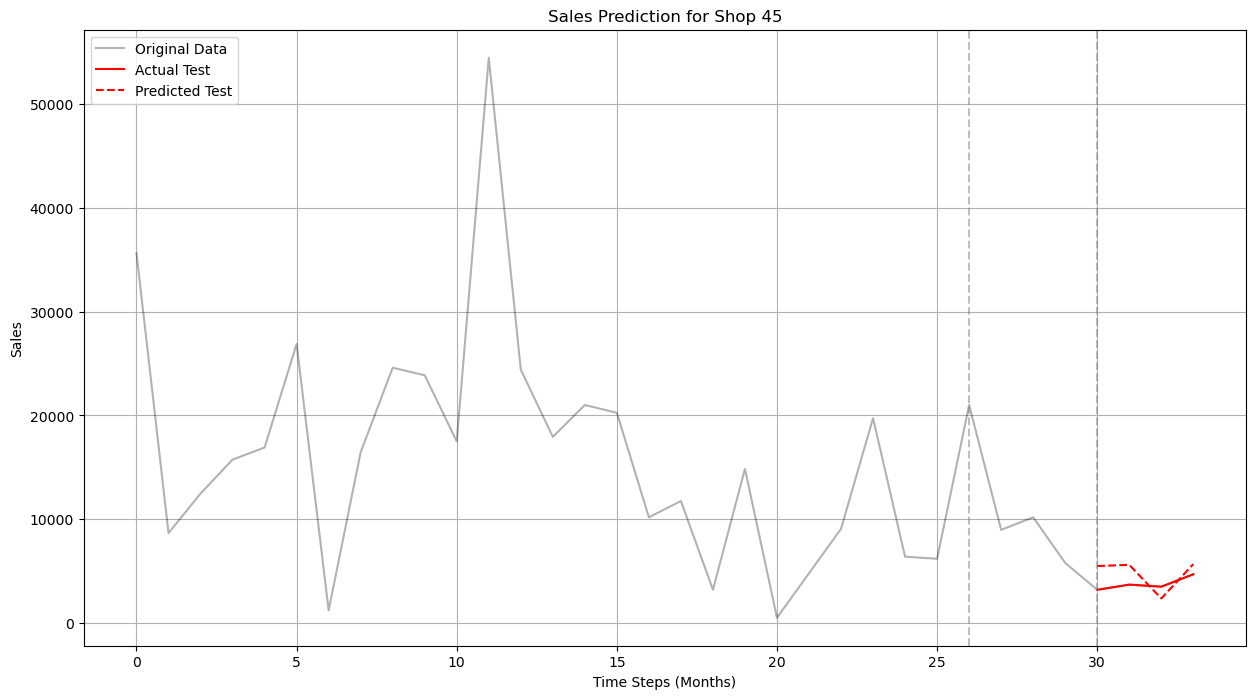


Shop 46:
MSE: 223685992.52
MAE: 11557.17


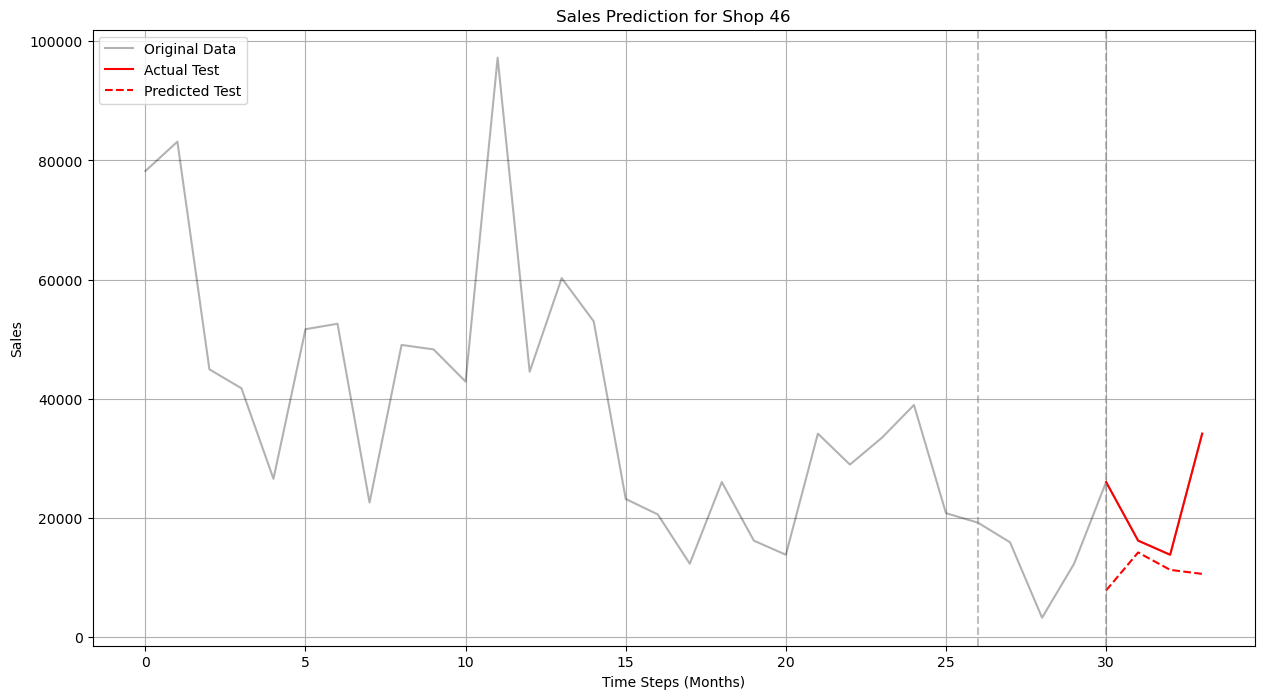


Shop 47:
MSE: 72262148.70
MAE: 6688.10


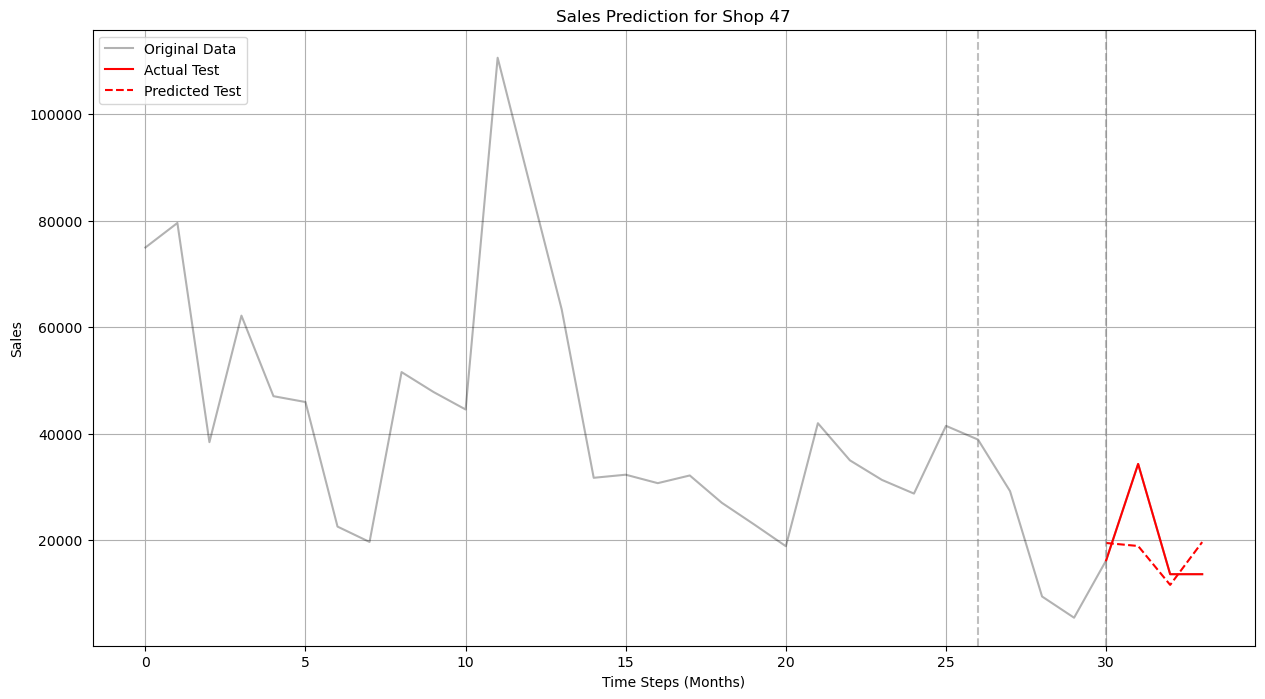


Shop 48:
MSE: 84229564.49
MAE: 8927.95


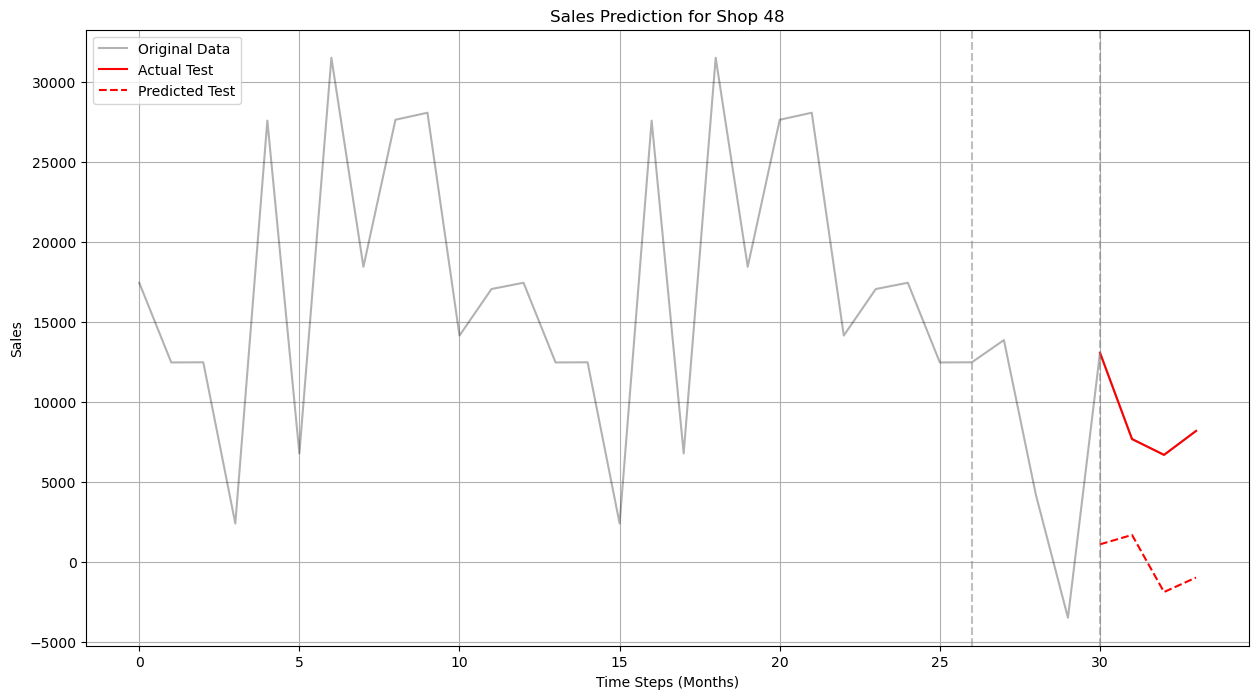


Shop 49:
MSE: 1709439.34
MAE: 1025.04


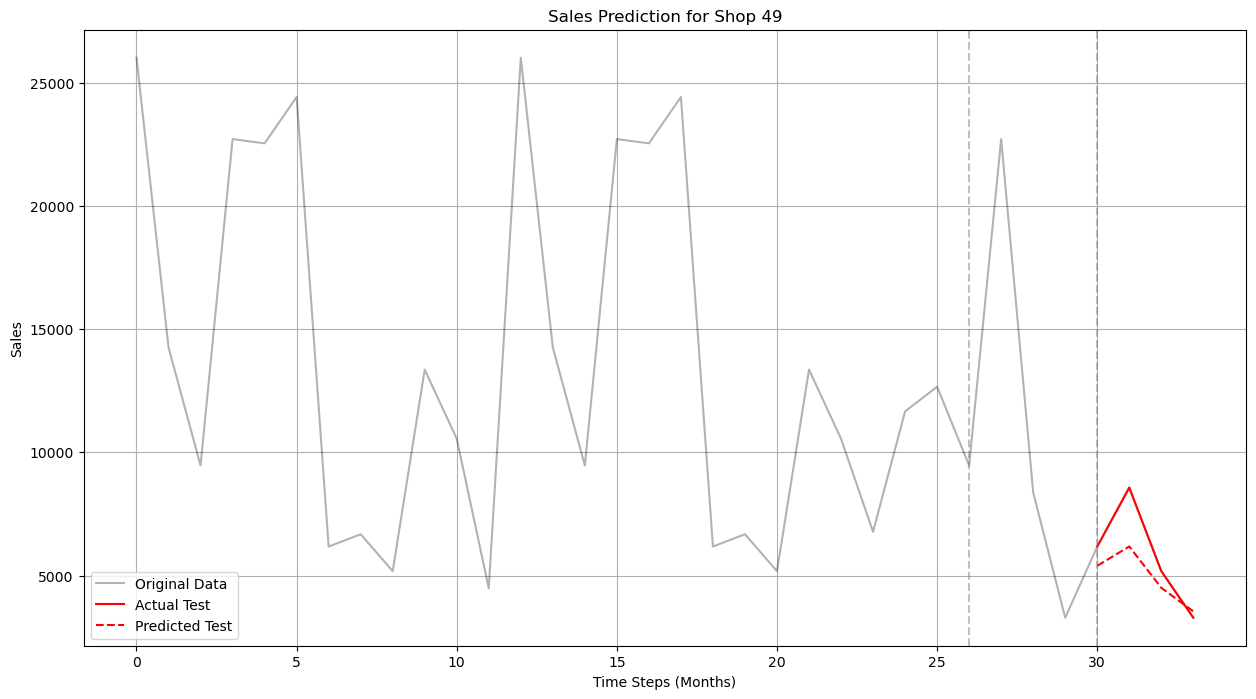


Shop 50:
MSE: 49200383.17
MAE: 5917.41


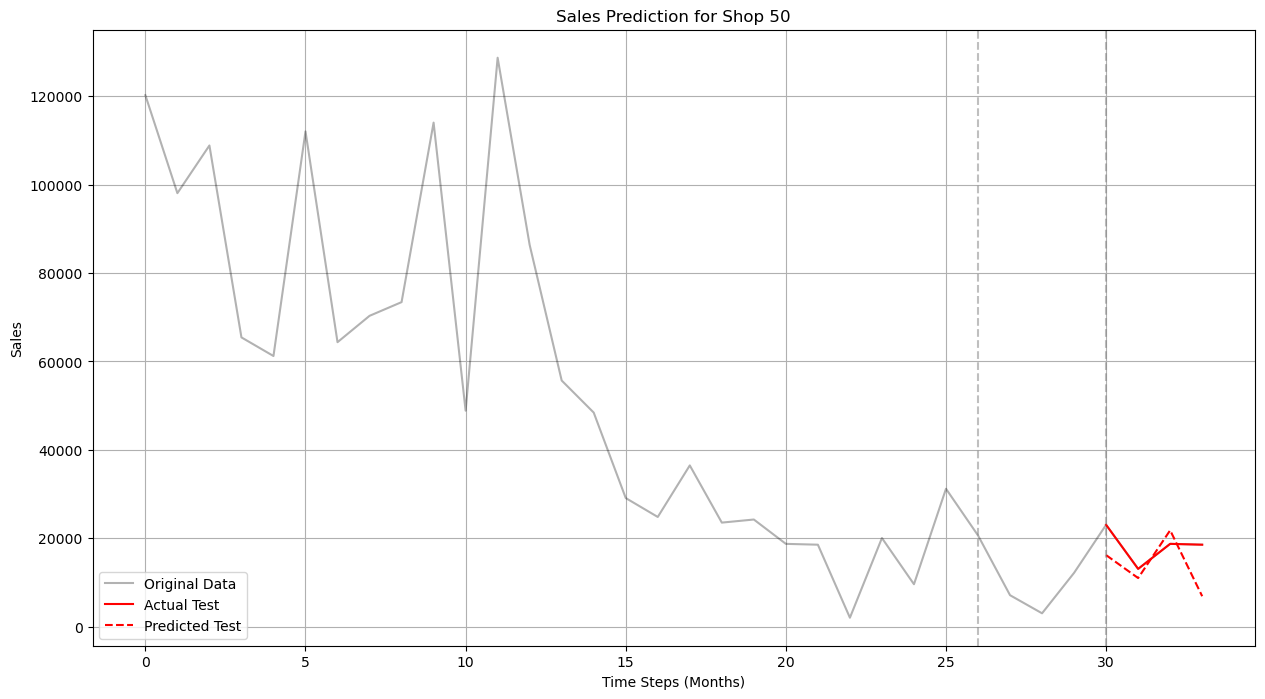


Shop 51:
MSE: 6623700.68
MAE: 2022.29


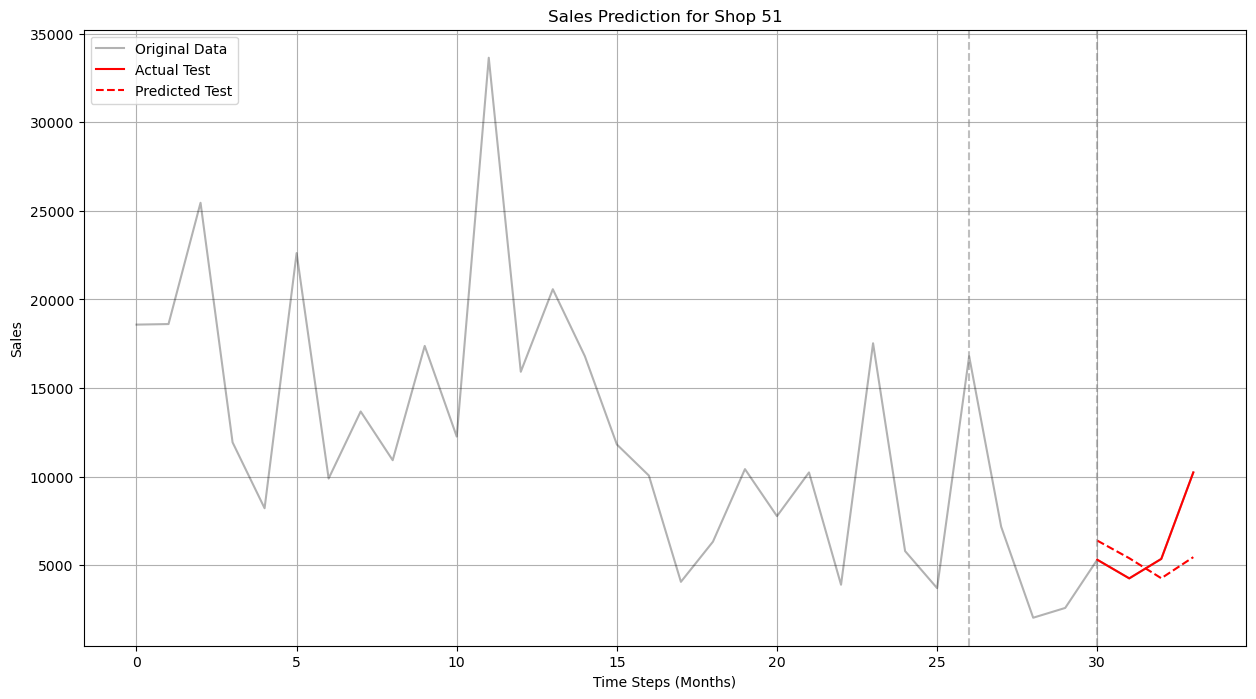


Shop 52:
MSE: 5203761.04
MAE: 1716.70


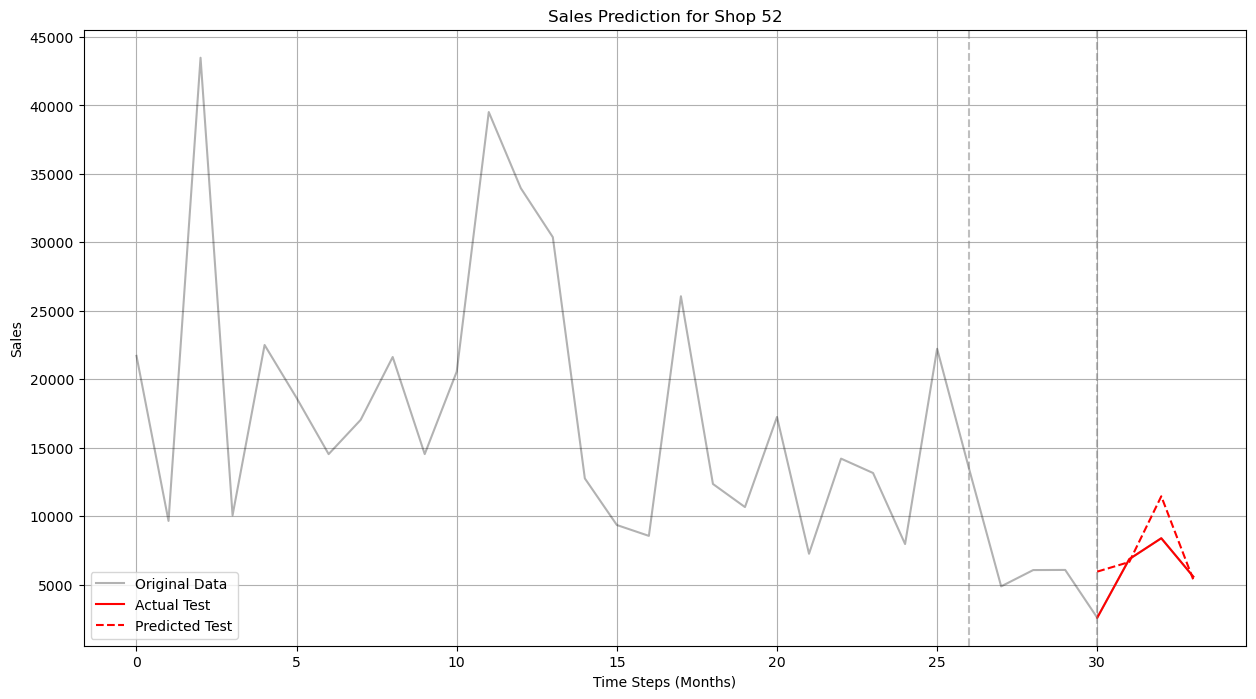


Shop 53:
MSE: 27820567.85
MAE: 4185.09


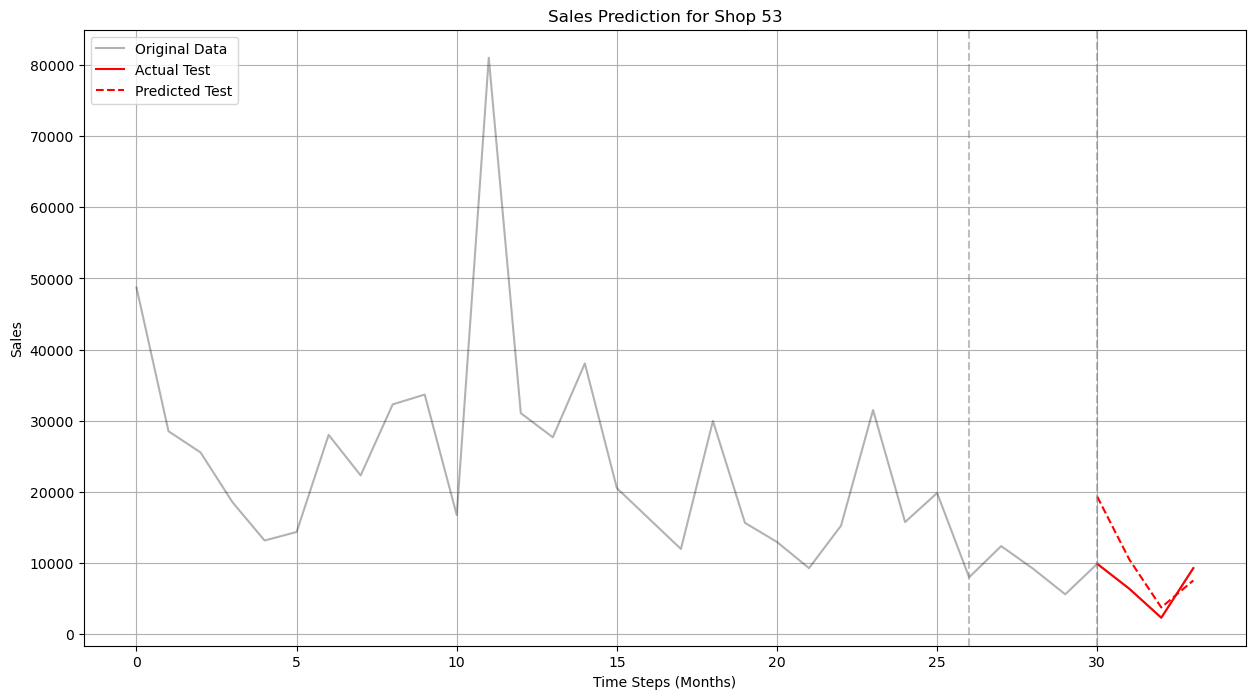


Shop 54:
MSE: 163050204.89
MAE: 10745.45


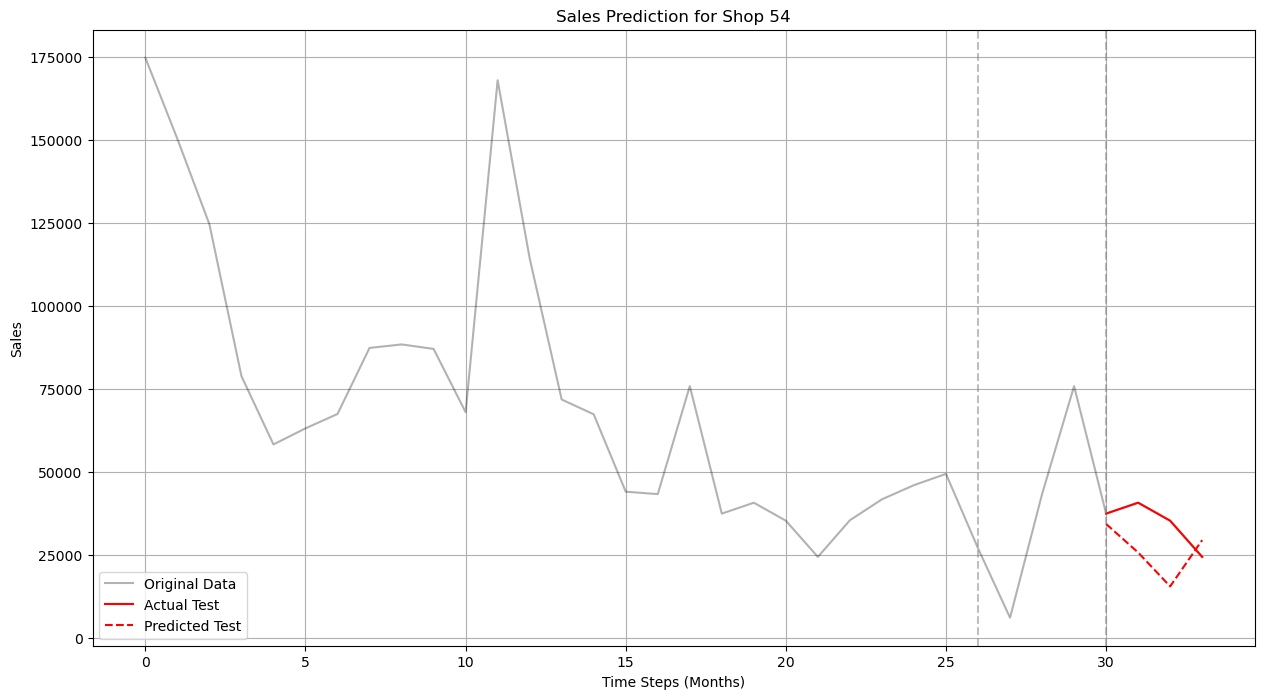


Shop 56:
MSE: 30128220.00
MAE: 4633.44


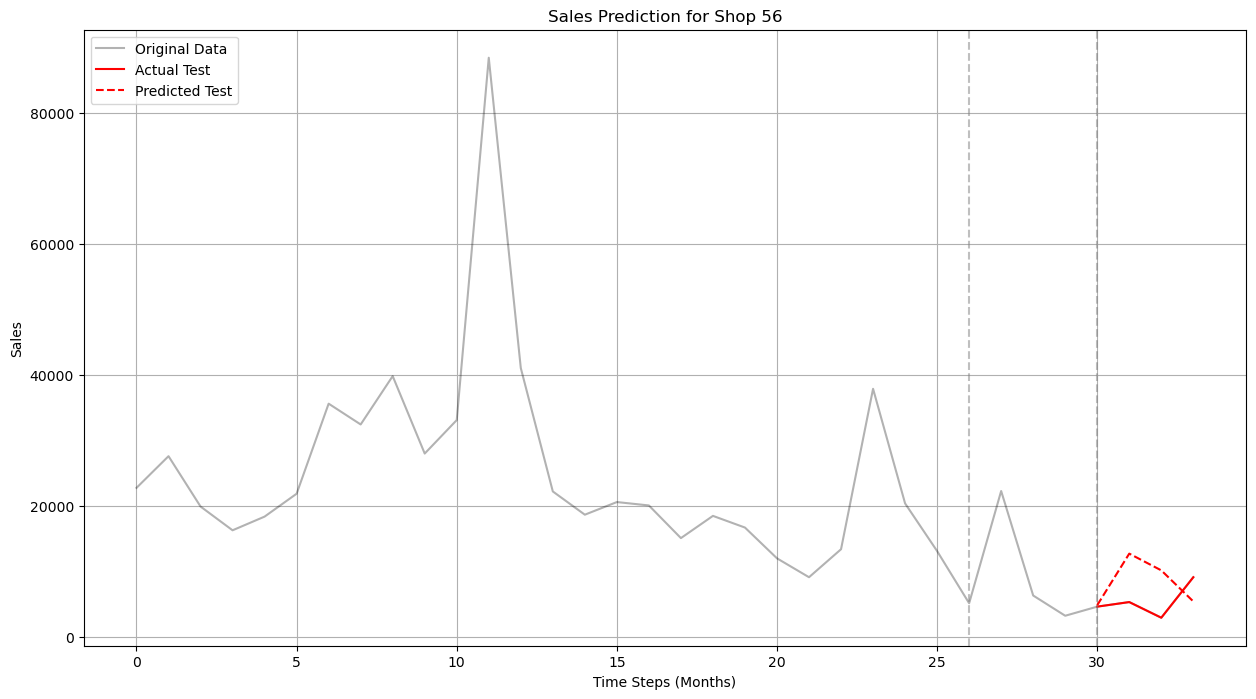


Shop 57:
MSE: 312866662.83
MAE: 13522.39


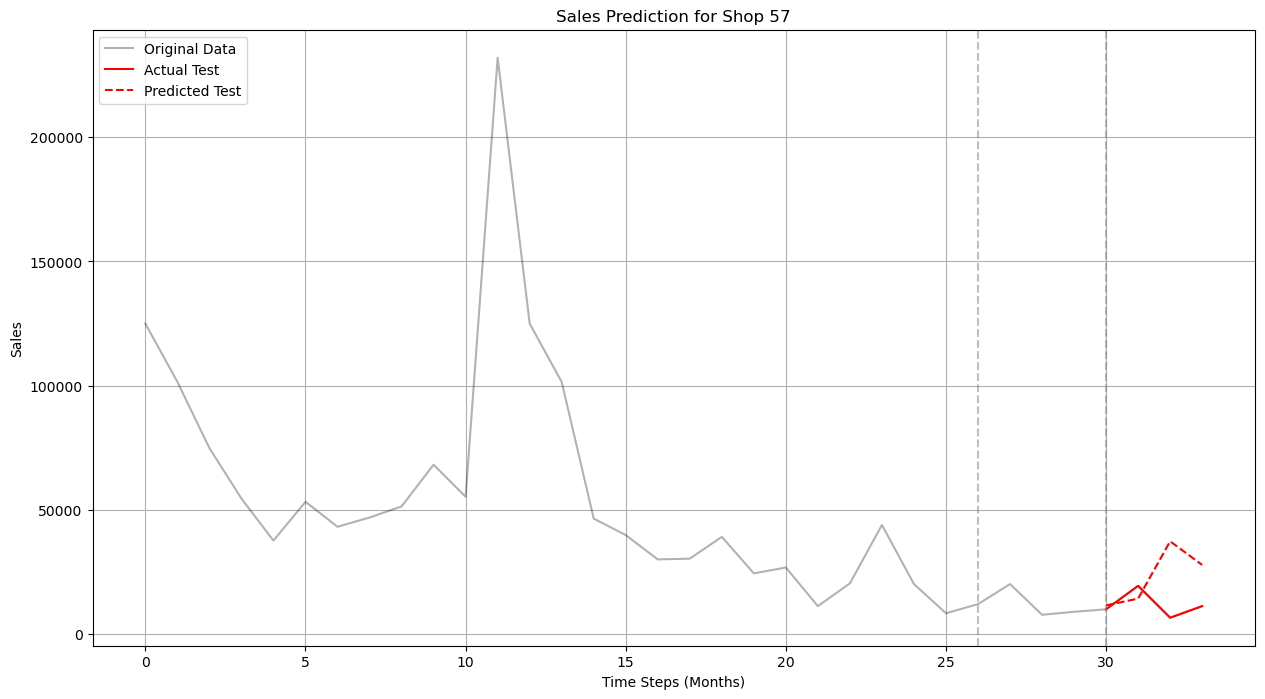


Shop 58:
MSE: 64388231.80
MAE: 6828.93


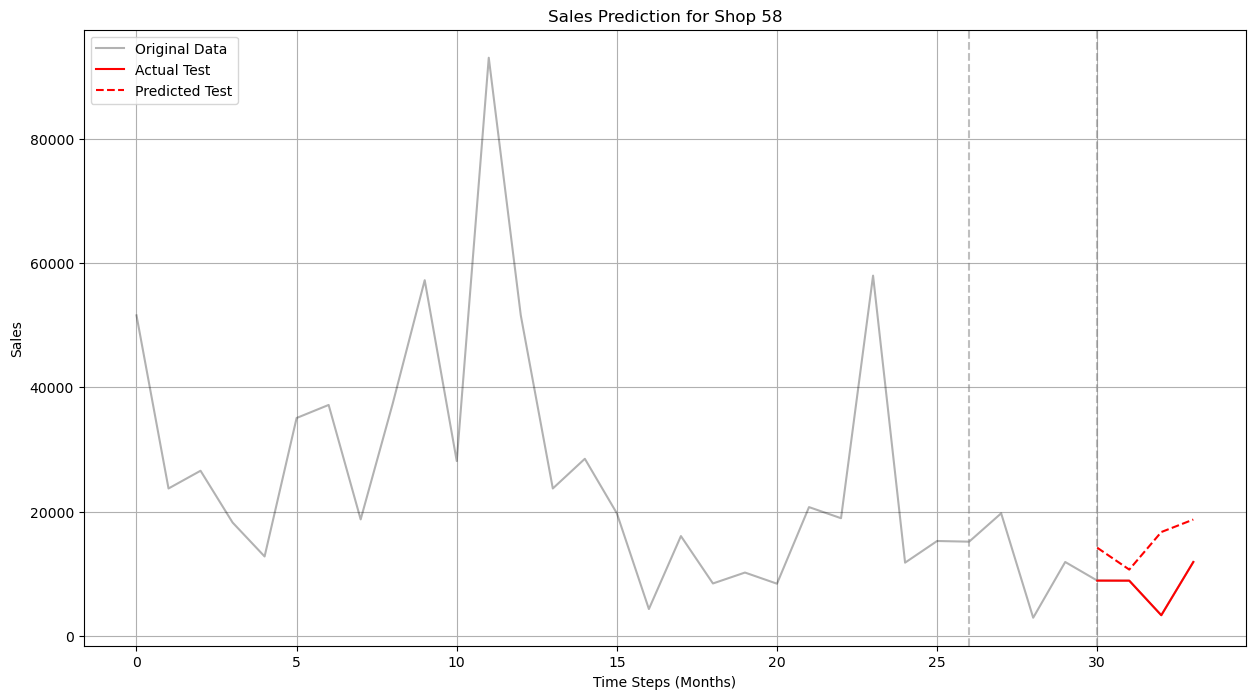


Shop 59:
MSE: 82068009.96
MAE: 6522.37


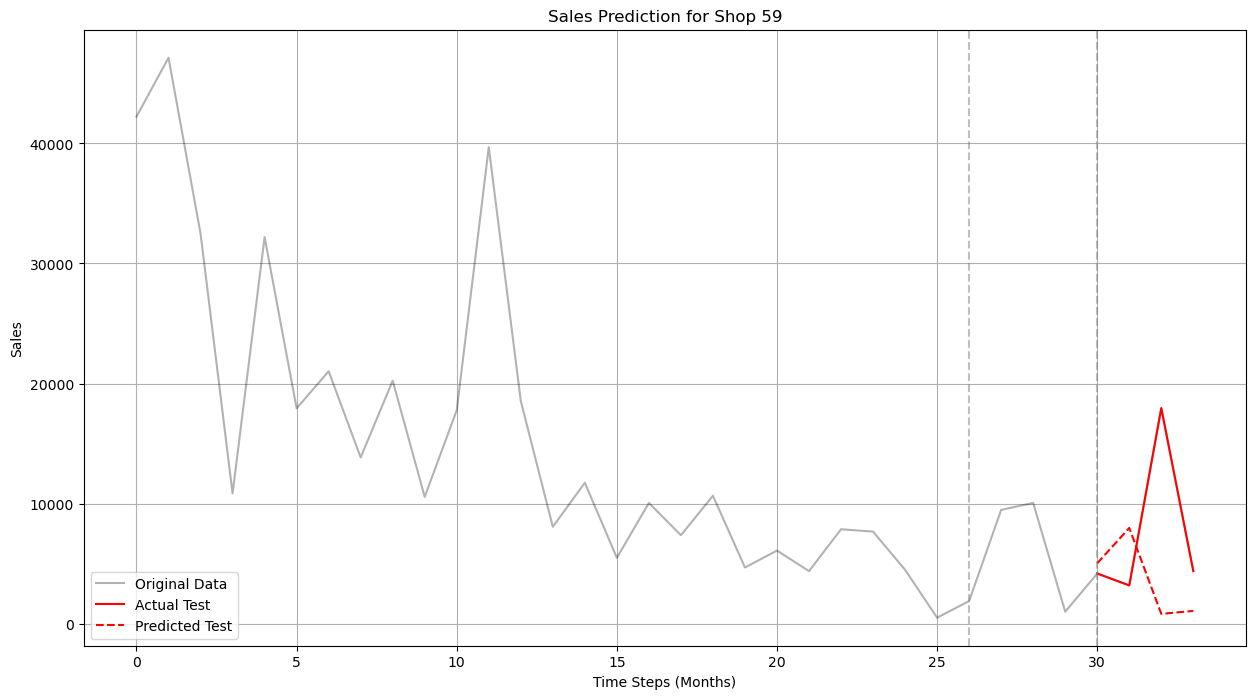


Overall Test Results:
MSE: 104872300.78
MAE: 7162.65
SMAPE: 64.48%


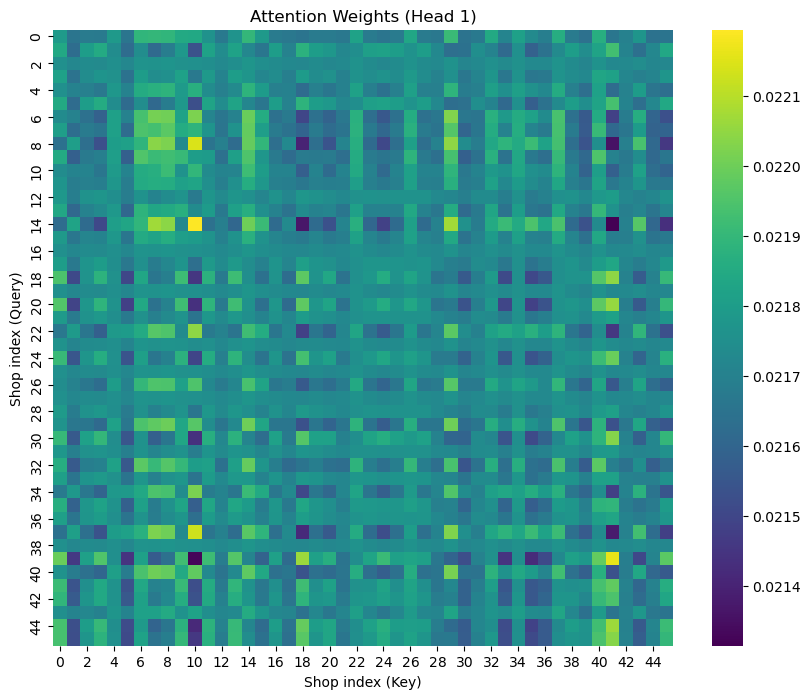

In [17]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt

import random


class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

def create_sequences(data, seq_length, pred_length):

    sequences = []
    targets = []
    
    for i in range(data.shape[1] - seq_length - pred_length + 1):
        seq = data[:, i:(i + seq_length)]
        target = data[:, (i + seq_length):(i + seq_length + pred_length)]
        sequences.append(seq)
        targets.append(target)
    
    return np.array(sequences), np.array(targets)


def main():
    # Load data
    df = pd.read_csv('sales_full_bymonth.csv')
    
    # Actual shop IDs
    shop_ids = [2, 3, 4, 5, 6, 7, 10, 12, 14, 15, 16, 17, 18, 19, 21, 22, 
                24, 25, 26, 27, 28, 29, 30, 31, 35, 37, 38, 39, 41, 42, 43, 
                44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59]
    
    # Parameters
    seq_length = 12
    pred_length = 4
    batch_size = 32
    num_epochs = 500
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    num_shops = len(shop_ids)
    sales_matrix = np.zeros((num_shops, 34))
    
    for idx, shop_id in enumerate(shop_ids):
        shop_data = df[df['shop_id'] == shop_id]['item_sales_month'].values
        sales_matrix[idx, :] = shop_data
    
    print("Sales matrix shape:", sales_matrix.shape)
    
    scaler = MinMaxScaler()
    sales_matrix_scaled = scaler.fit_transform(sales_matrix.T).T
    
    train_data = sales_matrix_scaled[:, :26]  # 0-26
    val_data = sales_matrix_scaled[:, 26:30]  # 27-30
    test_data = sales_matrix_scaled[:, 30:]   # 31-33
    
    print("Train data shape:", train_data.shape)
    print("Val data shape:", val_data.shape)
    print("Test data shape:", test_data.shape)
    
    train_sequences, train_targets = create_sequences(train_data, seq_length, pred_length)
    print("Train sequences shape:", train_sequences.shape)
    print("Train targets shape:", train_targets.shape)
    
    val_history = np.concatenate([train_data[:, -seq_length:], val_data], axis=1)
    print("Val history shape:", val_history.shape)
    val_sequences, val_targets = create_sequences(val_history, seq_length, pred_length)
    print("Val sequences shape:", val_sequences.shape)
    print("Val targets shape:", val_targets.shape)
    
    test_history = np.concatenate([val_data[:, -seq_length:], test_data], axis=1)
    print("Test history shape:", test_history.shape)
    
    test_sequences = test_history[:, :seq_length]  
    print("Test sequences before reshape:", test_sequences.shape)
    test_sequences = np.expand_dims(test_sequences, axis=0)  
    print("Test sequences after reshape:", test_sequences.shape)
    
    train_dataset = TimeSeriesDataset(
        torch.FloatTensor(train_sequences),
        torch.FloatTensor(train_targets)
    )
    val_dataset = TimeSeriesDataset(
        torch.FloatTensor(val_sequences),
        torch.FloatTensor(val_targets)
    )    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    

    num_channels = [32, 64, 184]
    model = TCNPredictor(
        num_shops=num_shops,
        num_channels=num_channels,
        kernel_size=3,
        dropout=0.2,
        pred_length=pred_length,
        d_model=4,        
        num_heads=2       
    ).to(device)

    

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    best_val_loss = float('inf')
    patience = 5
    counter = 0
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for sequences, targets in train_loader:
            sequences = sequences.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for sequences, targets in val_loader:
                sequences = sequences.to(device)
                targets = targets.to(device)
                
                outputs = model(sequences)
                loss = criterion(outputs, targets)
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            torch.save(model.state_dict(), 'tcn_model.pth')
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered")
                break
    
    model.load_state_dict(torch.load('tcn_model.pth'))
    model.eval()
    
    with torch.no_grad():
        test_sequences_tensor = torch.FloatTensor(test_sequences).to(device)
        test_predictions = model(test_sequences_tensor)
        test_predictions = test_predictions.cpu().numpy().squeeze()
        attn_weights = model.attn_weights  # [num_heads, num_shops, num_shops]

    test_predictions_original = scaler.inverse_transform(test_predictions.T).T
    test_actual_original = scaler.inverse_transform(test_data.T).T
    
    print("\nTest Set Results:")
    for i, shop_id in enumerate(shop_ids):
        mse = np.mean((test_actual_original[i] - test_predictions_original[i]) ** 2)
        mae = np.mean(np.abs(test_actual_original[i] - test_predictions_original[i]))
        print(f"\nShop {shop_id}:")
        print(f"MSE: {mse:.2f}")
        print(f"MAE: {mae:.2f}")
        
        plt.figure(figsize=(15, 8))
        plt.plot(range(34), sales_matrix[i], 'k-', label='Original Data', alpha=0.3)
        plt.plot(range(30, 34), test_actual_original[i], 'r-', label='Actual Test')
        plt.plot(range(30, 34), test_predictions_original[i], 'r--', label='Predicted Test')
        
        plt.axvline(x=26, color='gray', linestyle='--', alpha=0.5)
        plt.axvline(x=30, color='gray', linestyle='--', alpha=0.5)
        
        plt.title(f'Sales Prediction for Shop {shop_id}')
        plt.xlabel('Time Steps (Months)')
        plt.ylabel('Sales')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    overall_mse = np.mean((test_actual_original - test_predictions_original) ** 2)
    overall_mae = np.mean(np.abs(test_actual_original - test_predictions_original))
    overall_smape = smape(test_actual_original, test_predictions_original)
    print("\nOverall Test Results:")
    print(f"MSE: {overall_mse:.2f}")
    print(f"MAE: {overall_mae:.2f}")
    print(f"SMAPE: {overall_smape:.2f}%")



    for head_idx in range(attn_weights.shape[0]):
        plt.figure(figsize=(10,8))
        sns.heatmap(attn_weights[head_idx], annot=False, cmap='viridis')
        plt.title(f'Attention Weights (Head {head_idx+1})')
        plt.xlabel('Shop index (Key)')
        plt.ylabel('Shop index (Query)')
        plt.show()


if __name__ == '__main__':
    seed = 23
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    main()